# Problem Set 2

This problem set will give you the opportunity to download and analyze a small corpus of mobile phone metadata, in order to study the internal migration response to a major earthquake.  The problem set relates loosely to several papers discussed in the class, and in particular to <a href='http://www.sciencedirect.com/science/article/pii/S0304387816000109'>"Airtime Transfers and Mobile Communications: Evidence in the Aftermath of Natural Disasters"</a>. You might wish to familiarize yourself with this paper before beginning the assignment.

![title](datasets/heatmap.png)

## Overview of the problem set

These are the key steps in the problem set:

1. Download the CDR and familiarize yourself with the dataset
2. Develop a method for detecting a "migration" event
3. Analyze the migration response to the Lake Kivu earthquake

<div style="background-color: #33A;height: 20px"></div>

## Imports all in one place

In [1]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Everett Wetchler 2019-03-31 11:23:36 PDT

CPython 3.7.2
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
seaborn 0.9.0
watermark 1.8.1


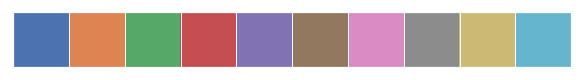

In [53]:
import datetime as dt
import datetime
import os
import random
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [3]:
# Additional imports for this project
import geopandas
import geoplot
from shapely.geometry import Point
from shapely import geometry

<div style="background-color: #3A3;height: 20px"></div>

# 1. Conduct exploratory analysis of the Call Detail Records

Download the three datasets from the course website (available on bCourses under files/PS2).
- `cdr_sample.zip`: This dataset contains the full Call Detail Records of a few thousand individuals. These data have been pseudonymized and partially fabricated, to ensure the privacy and confidentiality of the subscribers. However, the data are not that different from the raw data that are collected by mobile phone operators throughout the world. 
    - There are six columns in this dataset: user_1 (ID of person placing call), user_2 (ID of person receiving call), date, time, tower_1 (location of user_1), and tower_2 (location of user_2). We have strategically sampled ~3600 users and their full call detail records. The users in the column user_1 are these 3600 users.
    - Note that the column user_2 might also contain those ~3600 users. Therefore, when calculating the number of logged events per person, don't forget the column user_2. 
- `celltower_location.csv`: This dataset contains the geocordinates of each cell tower, along with the district in which it is located. We added some jitter to the original coordinates, but each tower still belongs to its original district. 
- `District_Boundary_2012_merge_kigali.zip`: This dataset is the district [shapefile](https://en.wikipedia.org/wiki/Shapefile) of Rwanda. There are 30 districts in Rwanda, but we have merged the 3 districts that comprise the capital of Kigali. Thus, you will find 28 districts in the dataset.

<div style="background-color: #3A3;height: 10px"></div>

## 1.1 Present basic descriptive statistics, tables, and figures, to summarize the data

Construct a set of tables and figures that summarize key characteristics of this dataset: how many unique individuals, what time period is covered, how many events are logged per person, and so forth. Imagine that you are constructing the first tables and figures in a research paper, and you wish to provide your reader with as much intuition as possible about what information is contained in your dataset. Be creative, but be disciplined. Your figures should be professional, carefully labelled, and easily interpreted.

In [4]:

cdr_data = pd.read_csv("datasets/cdr/cdr_sample.csv") 
cdr_data.head()

,user_1,user_2,date,time,tower_1,tower_2
0,L55737047,L02196776,80617,18:30:17,9,9
1,L55737047,L45332350,80730,21:33:08,47,47
2,L55737047,L87926818,80422,14:25:31,74,74
3,L55737047,L87926818,80408,15:23:13,20,46
4,L55737047,L87926818,80123,17:35:49,171,171


In [5]:
# Uniques across each column
cdr_data.nunique()

user_1       3610
user_2     185497
date          366
time        85810
tower_1       170
tower_2       170
dtype: int64

In [6]:
user_columns = pd.concat([cdr_data.user_1, cdr_data.user_2], axis=0, sort=False)
# number of unique users (either in user_1 or user_2 columns)
user_columns.nunique()

185987

In [21]:
SAMPLE_FRAC = None
cdr = pd.read_csv('datasets/cdr/cdr_sample.csv')
print("%d rows x %d cols" % cdr.shape)
if SAMPLE_FRAC:
    all_users = set(cdr.user_1.to_list() + cdr.user_2.to_list())
    samp_users = random.sample(list(all_users), int(len(all_users) * SAMPLE_FRAC))
    print("Downsampling from %d users to %d users." % (len(all_users), len(samp_users)))
    cdr = cdr[cdr.user_1.isin(samp_users) | cdr.user_2.isin(samp_users)]
    print("New CDR shape (keeping calls where one of these users is involved): %d rows x %d cols" % cdr.shape)
cdr.head()

4388305 rows x 6 cols


,user_1,user_2,date,time,tower_1,tower_2
0,L55737047,L02196776,80617,18:30:17,9,9
1,L55737047,L45332350,80730,21:33:08,47,47
2,L55737047,L87926818,80422,14:25:31,74,74
3,L55737047,L87926818,80408,15:23:13,20,46
4,L55737047,L87926818,80123,17:35:49,171,171


In [25]:
def extract_date(s):
    return dt.date(s // 10000 + 2000, (s % 10000) // 100, s % 100)
cdr['date'] = pd.to_datetime(cdr.date.apply(extract_date))
cdr.head()

,user_1,user_2,date,time,tower_1,tower_2
0,L55737047,L02196776,2008-06-17,18:30:17,9,9
1,L55737047,L45332350,2008-07-30,21:33:08,47,47
2,L55737047,L87926818,2008-04-22,14:25:31,74,74
3,L55737047,L87926818,2008-04-08,15:23:13,20,46
4,L55737047,L87926818,2008-01-23,17:35:49,171,171


In [29]:
towers = pd.read_csv('datasets/cdr/celltower_location.csv')
towers.set_index('antenna_id', drop=False, inplace=True)
print("%d rows x %d cols" % towers.shape)
towers.head()

267 rows x 4 cols


,antenna_id,longitude,latitude,district
antenna_id,,,,
1,1,30.096104,-1.931660,Kigali
3,3,30.122176,-1.997260,Kigali
4,4,30.070381,-1.951818,Kigali
5,5,30.062391,-1.918881,Kigali
6,6,30.159390,-2.017144,Kigali


In [10]:
print("There are " + str(cdr_data['user_1'].shape[0]) + " total calls. ")

print("The data covers the period from " + str(cdr['date'].min()) +  " to "+ str(cdr['date'].max()) + " which is " + str(cdr['date'].max() - cdr['date'].min()))

There are 4388305 total calls. 
The data covers the period from 2007-08-01 00:00:00 to 2008-07-31 00:00:00 which is 365 days 00:00:00


## Overall Data Exploration

Below are further explorations for all logged events by distribution for all user_1, user_2, date, tower_1, tower_2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b74734fd0>,
      dtype=object)

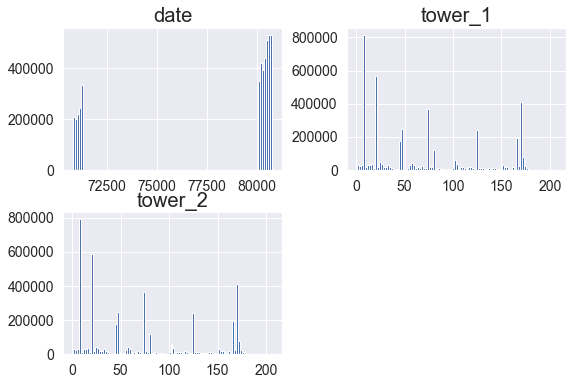

In [144]:
# histograms for number of calls made on date and at tower_1 or tower_2

cdr_data.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a36d6beb8>,
      dtype=object)

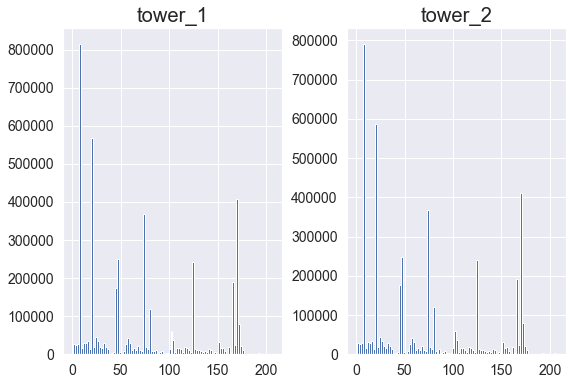

In [145]:
# histograms for number of calls made on date and at tower_1 or tower_2

cdr.hist(bins=100)

Text(0, 0.5, 'Number of calls')

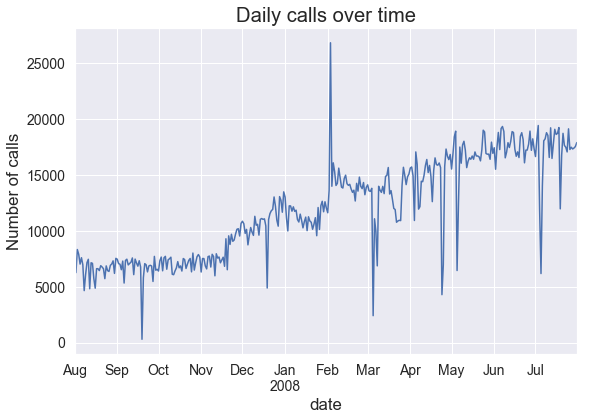

In [146]:
fig, ax = plt.subplots(1)
cdr.groupby(cdr.date).size().sort_index().plot(ax=ax)
ax.set_title("Daily calls over time")
ax.set_ylabel("Number of calls")

In [147]:
def get_weekday(row):
    return row.date.weekday()
cdr['weekday'] = cdr.apply(get_weekday, axis=1)

In [148]:
cdr.head()

,user_1,user_2,date,time,tower_1,tower_2,tower_1_district,tower_2_district,weekday
0,L55737047,L02196776,2008-06-17,18:30:17,9,9,Rusizi,Rusizi,1
1,L55737047,L45332350,2008-07-30,21:33:08,47,47,Nyamasheke,Nyamasheke,2
2,L55737047,L87926818,2008-04-22,14:25:31,74,74,Nyamasheke,Nyamasheke,1
3,L55737047,L87926818,2008-04-08,15:23:13,20,46,Rusizi,Rusizi,1
4,L55737047,L87926818,2008-01-23,17:35:49,171,171,Rusizi,Rusizi,2


[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

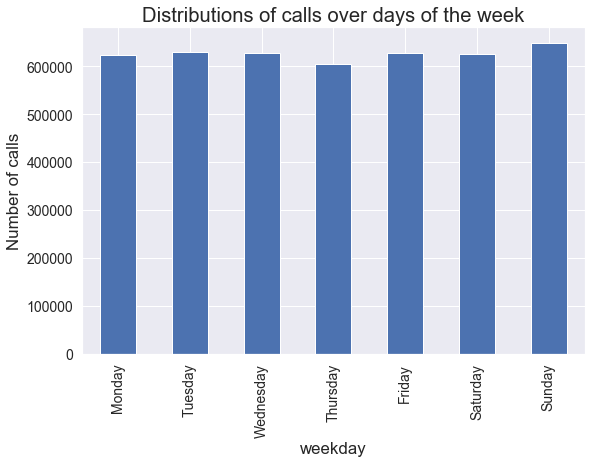

In [149]:
fig, ax = plt.subplots(1)
cdr.groupby(cdr.weekday).size().sort_index().plot(ax=ax, kind='bar')
ax.set_title("Distributions of calls over days of the week")
ax.set_ylabel("Number of calls")
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
# 0 = Monday, 6 = Sunday

### Distribution of Number of Calls



Total calls 4388305
Lowest number of calls is 1 with 7 people
Highest number of calls is 21644 with 1 people
average is 1.8772750910036402
Number of people with 2 calls is 6


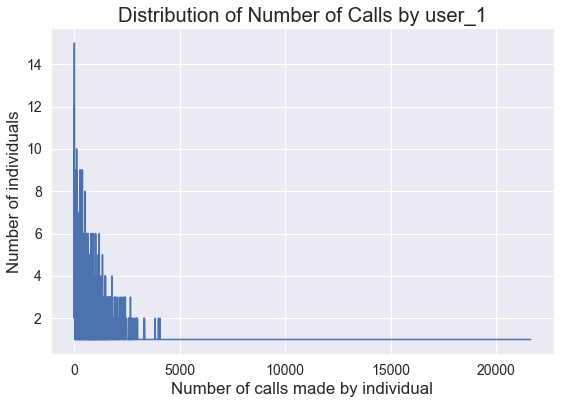

In [12]:
# number of logged events per person
# for user 1
user_1_counts = cdr_data['user_1'].value_counts()
print("Total calls " + str(cdr_data['user_1'].shape[0]))
# print("Sum of calls by user_1 is " + str(user_1_counts.sum()))
# user_1_counts.head()

user_1_call_dist = user_1_counts.value_counts().sort_index()
pl = user_1_call_dist.plot()
pl.set_title("Distribution of Number of Calls by user_1")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")

min_call = user_1_call_dist.index.min() # lowest number of calls
num_people = user_1_call_dist[min_call] # number of people with lowest number of calls
print("Lowest number of calls is " + str(min_call) + " with " + str(num_people) + " people")
max_call = user_1_call_dist.index.max() # highest number of calls
num_people = user_1_call_dist[max_call] # number of people with highest number of calls
print("Highest number of calls is " + str(max_call) + " with " + str(num_people) + " people")
print("average is " + str(user_1_call_dist.mean()))
print("Number of people with 2 calls is " + str(user_1_call_dist[2]))

Text(0, 0.5, 'Number of individuals')

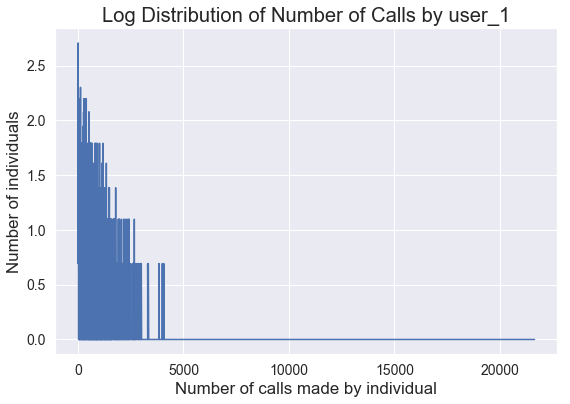

In [13]:
pl = np.log(user_1_call_dist).plot()
pl.set_title("Log Distribution of Number of Calls by user_1")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")

Total calls 4388305
Sum of calls by user_2 is 4388305
Lowest number of calls is 1 with 43861 people
Highest number of calls is 4963 with 1 people
average is 179.39748549323016
Number of people with 179 calls is 32
Number of people with 180 calls is 29


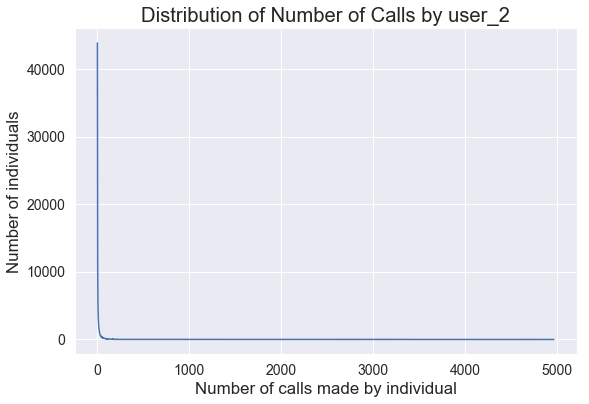

In [14]:
# for user 2
user_2_counts = cdr_data['user_2'].value_counts()
print("Total calls " + str(cdr_data['user_2'].shape[0]))
print("Sum of calls by user_2 is " + str(user_2_counts.sum()))
user_2_counts.head()

user_2_call_dist = user_2_counts.value_counts().sort_index()
pl = user_2_call_dist.plot()
pl.set_title("Distribution of Number of Calls by user_2")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")

min_call = user_2_call_dist.index.min() # lowest number of calls
num_people = user_2_call_dist[min_call] # number of people with lowest number of calls
print("Lowest number of calls is " + str(min_call) + " with " + str(num_people) + " people")
max_call = user_2_call_dist.index.max() # highest number of calls
num_people = user_2_call_dist[max_call] # number of people with highest number of calls
print("Highest number of calls is " + str(max_call) + " with " + str(num_people) + " people")
print("average is " + str(user_2_call_dist.mean()))
print("Number of people with 179 calls is " + str(user_2_call_dist[179]))
print("Number of people with 180 calls is " + str(user_2_call_dist[180]))

Text(0, 0.5, 'Number of individuals')

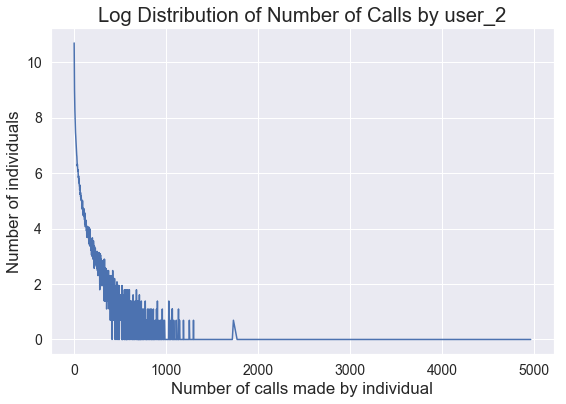

In [15]:
pl = np.log(user_2_call_dist).plot()
pl.set_title("Log Distribution of Number of Calls by user_2")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Tower Number')

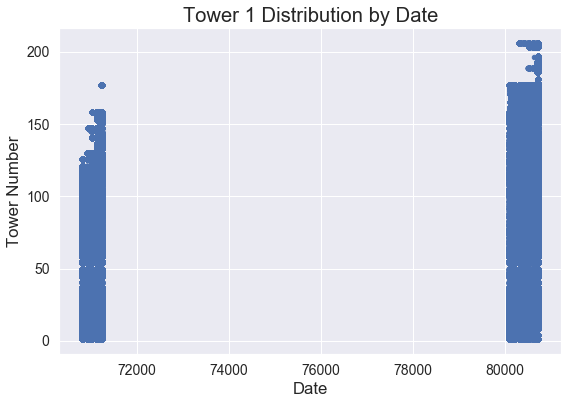

In [16]:
# Tower 1 distribution by date
pl = cdr_data.plot.scatter(x='date',y='tower_1')
pl.set_title("Tower 1 Distribution by Date")
pl.set_xlabel("Date")
pl.set_ylabel("Tower Number")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Tower Number')

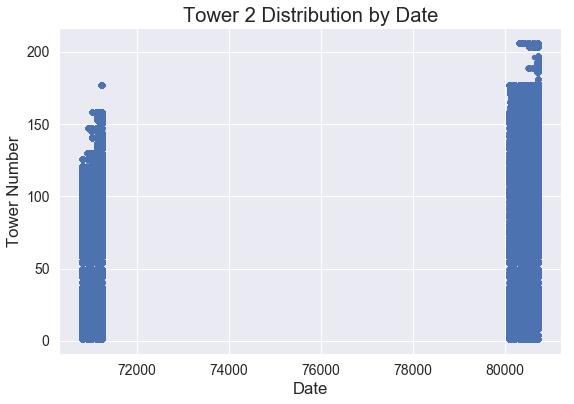

In [18]:
# Tower 2 distribution by date
pl = cdr_data.plot.scatter(x='date',y='tower_2')
pl.set_title("Tower 2 Distribution by Date")
pl.set_xlabel("Date")
pl.set_ylabel("Tower Number")

In [21]:
# cell tower data
celltower_data = pd.read_csv("datasets/celltower_location.csv")
celltower_data.head()

,antenna_id,longitude,latitude,district
0,1,30.096104,-1.931660,Kigali
1,3,30.122176,-1.997260,Kigali
2,4,30.070381,-1.951818,Kigali
3,5,30.062391,-1.918881,Kigali
4,6,30.159390,-2.017144,Kigali


In [22]:
# number of unique celltowers
celltower_data.nunique()

antenna_id    267
longitude     267
latitude      267
district       28
dtype: int64

### Overall Summary
Summary of general data exploration over all data is that there is a total of 4388305 calls. There are 3610 unique user_1, 185497 unique user_2, and 170 unique towers. Analyzing calls by user_1 versus user_2, we find that user_1 ranges from 1 call with 7 users to 21644 calls with 1 user. By user_2, there is 1 call with 43861 users and 4963 with 1 user. 


There are 4388305 total calls which covers a period of 365 days from 2007-08-01 to 2008-07-31.



### Investigation for data trends at user-specific level. 

Let us assume that user_1 is the person of interest, we will use user_1 = L00000743.

In [23]:
# by person
df_by_users = cdr_data.groupby(['user_1', 'user_2']).size()
df_by_users.head()

user_1     user_2   
L00000743  L05619134    3
           L17092021    1
           L23624445    2
           L24623833    2
           L24730347    1
dtype: int64

In [151]:
user1_data = cdr_data[cdr_data['user_1']=='L00000743']
user1_cdr = cdr[cdr['user_1']=='L00000743']
user1_data.head()

,user_1,user_2,date,time,tower_1,tower_2
3178013,L00000743,L26475286,71211,18:49:01,46,20
3178014,L00000743,L64001127,71006,13:43:46,80,80
3178015,L00000743,L98971936,70928,14:00:17,20,20
3178016,L00000743,L36795910,71217,11:59:48,80,80
3178017,L00000743,L41757282,71216,10:48:50,3,86


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23d8aa58>,
      dtype=object)

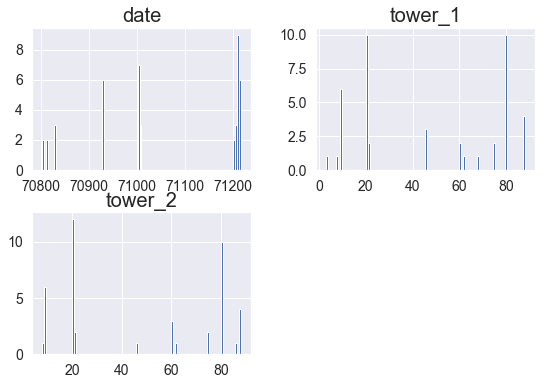

In [25]:
user1_data.hist(bins=100)

Text(0, 0.5, 'Dates')

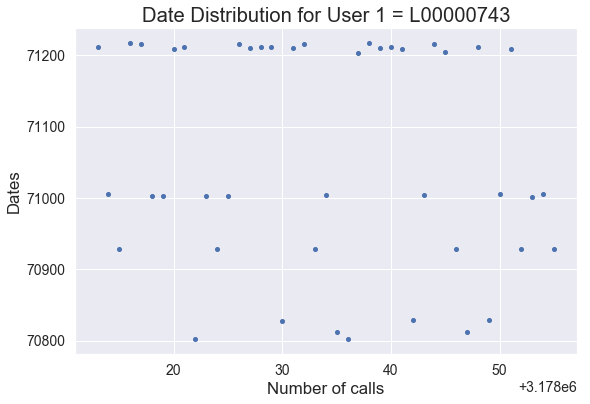

In [26]:
pl = user1_data.date.plot(marker='o',  markersize=4, linewidth='0')
pl.set_title("Date Distribution for User 1 = L00000743")
pl.set_xlabel("Number of calls")
pl.set_ylabel("Dates")

Text(0, 0.5, 'Tower Number')

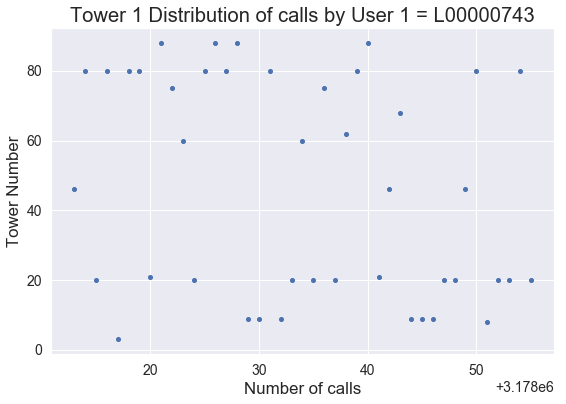

In [27]:
pl = user1_data.tower_1.plot(marker='o',  markersize=4, linewidth='0')
pl.set_title("Tower 1 Distribution of calls by User 1 = L00000743")
pl.set_xlabel("Number of calls")
pl.set_ylabel("Tower Number")


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Tower Number')

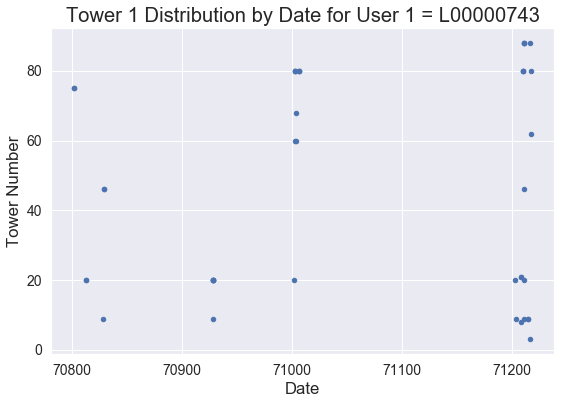

In [28]:
# Tower 1 distribution by date
pl = user1_data.plot.scatter(x='date',y='tower_1')
pl.set_title("Tower 1 Distribution by Date for User 1 = L00000743")
pl.set_xlabel("Date")
pl.set_ylabel("Tower Number")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Tower Number')

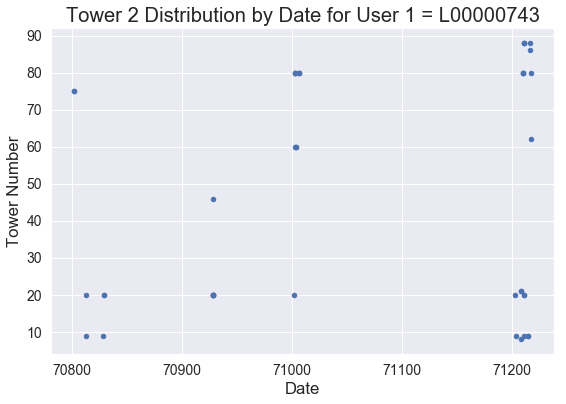

In [29]:
# Tower 2 distribution by date
pl = user1_data.plot.scatter(x='date',y='tower_2')
pl.set_title("Tower 2 Distribution by Date for User 1 = L00000743")
pl.set_xlabel("Date")
pl.set_ylabel("Tower Number")

Text(0, 0.5, 'Number of calls')

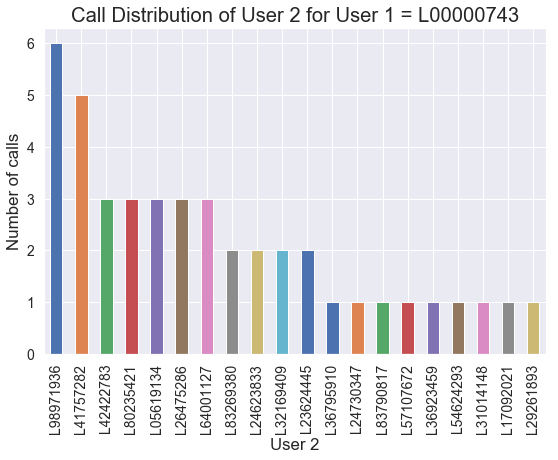

In [30]:
pl = user1_data['user_2'].value_counts().plot(kind='bar')
pl.set_title("Call Distribution of User 2 for User 1 = L00000743")
pl.set_xlabel("User 2")
pl.set_ylabel("Number of calls")

Text(0, 0.5, 'Number of calls')

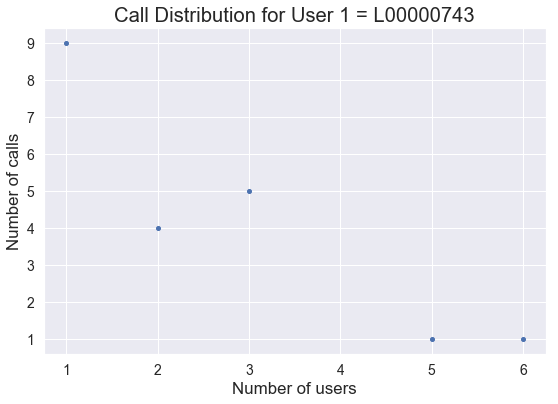

In [31]:
pl = user1_data['user_2'].value_counts().value_counts().sort_index().plot(marker='o',  markersize=4, linewidth='0')
pl.set_title("Call Distribution for User 1 = L00000743")
pl.set_xlabel("Number of users")
pl.set_ylabel("Number of calls")



Text(0, 0.5, 'Number of calls')

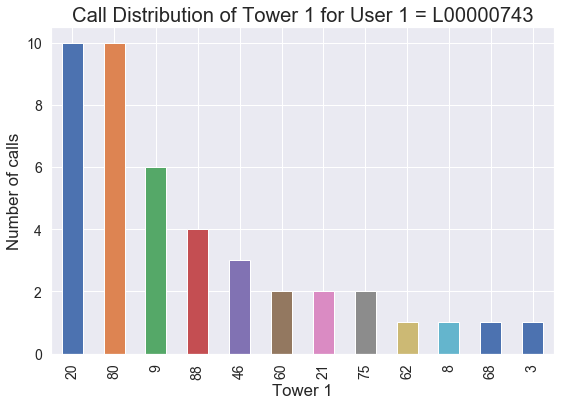

In [32]:
pl = user1_data['tower_1'].value_counts().plot(kind='bar')
pl.set_title("Call Distribution of Tower 1 for User 1 = L00000743")
pl.set_xlabel("Tower 1")
pl.set_ylabel("Number of calls")

Text(0, 0.5, 'Number of calls')

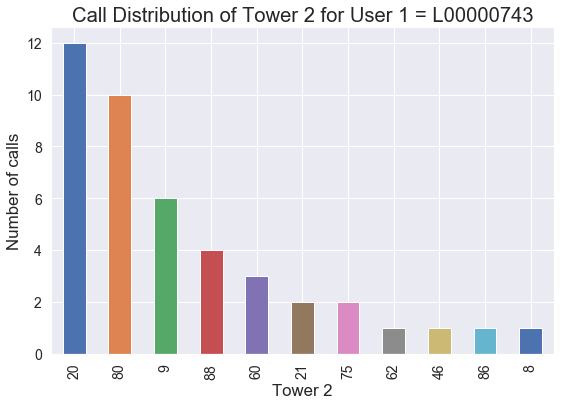

In [33]:
pl = user1_data['tower_2'].value_counts().plot(kind='bar')
pl.set_title("Call Distribution of Tower 2 for User 1 = L00000743")
pl.set_xlabel("Tower 2")
pl.set_ylabel("Number of calls")

Text(0, 0.5, 'Number of Calls')

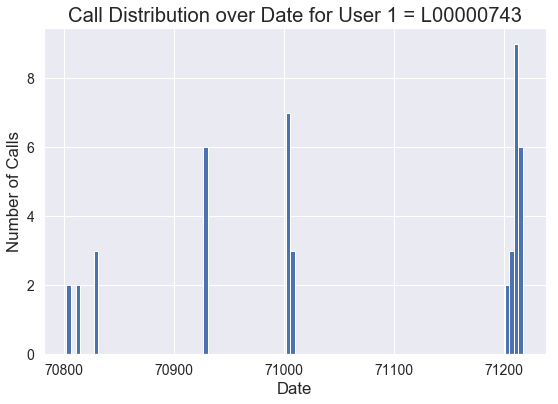

In [34]:
pl = user1_data.date.hist(bins=100)
pl.set_title("Call Distribution over Date for User 1 = L00000743")
pl.set_xlabel("Date")
pl.set_ylabel("Number of Calls")

Text(0, 0.5, 'Tower Number')

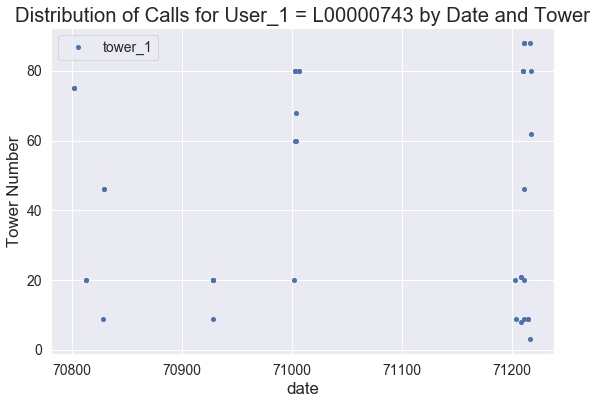

In [35]:
pl = user1_data.sort_values(by=['date']).plot(x='date', y ='tower_1', marker='o',  markersize=4, linewidth='0')
pl.set_title("Distribution of Calls for User_1 = L00000743 by Date and Tower")
# pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Tower Number")

Text(0, 0.5, 'Date')

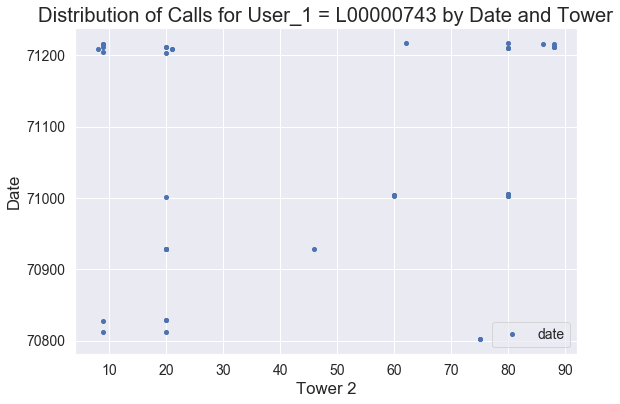

In [36]:
pl = user1_data.sort_values(by=['date']).plot(x='tower_2', y ='date', marker='o',  markersize=4, linewidth='0')
pl.set_title("Distribution of Calls for User_1 = L00000743 by Date and Tower")
pl.set_xlabel("Tower 2")
pl.set_ylabel("Date")

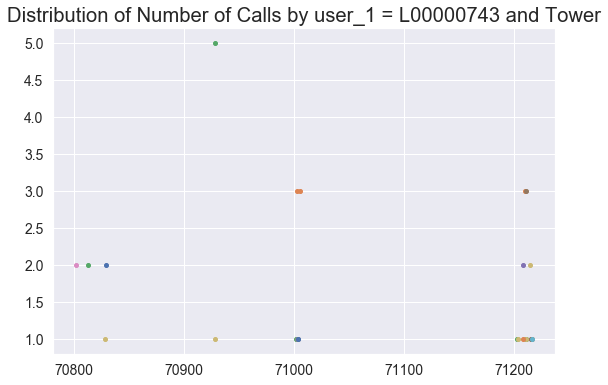

In [37]:
# get each tower_1 and then add to plot
df = user1_data
label = 'tower_1'
inner_label = 'date'
output = []
for key in df[label].unique():
    item = df[df[label] == key]
    x = []
    y = []
    for inner_key in item[inner_label].unique():
        inner_item = item[item[inner_label] == inner_key].sort_values(by=['date'])
        x.append(inner_key)
        y.append(len(inner_item))
    output.append([key, x, y])

for key, x, y in output:
    plt.plot(x, y, marker='o', markersize=4, linewidth=0, label=key)
# plt.legend()
plt.title("Distribution of Number of Calls by user_1 = L00000743 and Tower")
pl.set_xlabel("Date")
pl.set_ylabel("Number of Calls")
plt.show()

Text(0.5, 1.0, 'Calls over time for user_1 = L00000743')

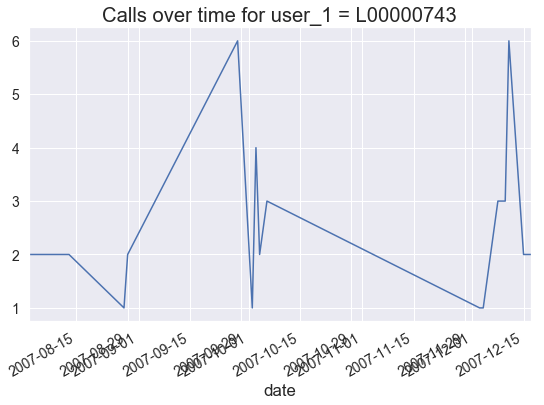

In [152]:
fig, ax = plt.subplots(1)
user1_cdr.groupby(user1_cdr.date).size().sort_index().plot(ax=ax)
ax.set_title("Calls over time for user_1 = L00000743")

Text(0, 0.5, 'Number of calls')

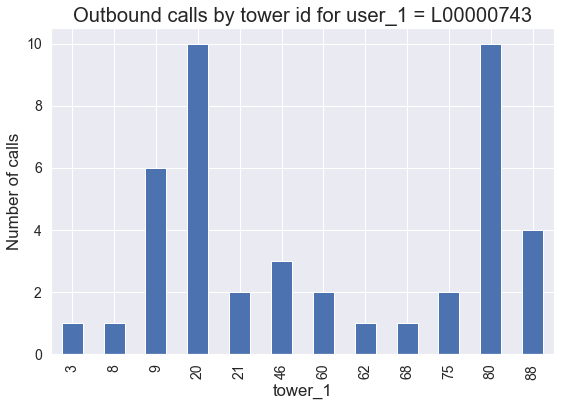

In [153]:
fig, ax = plt.subplots(1)
user1_cdr.groupby(user1_cdr.tower_1).size().sort_index().plot(ax=ax, kind='bar')
ax.set_title("Outbound calls by tower id for user_1 = L00000743")
ax.set_ylabel("Number of calls")

Text(0, 0.5, 'Number of calls')

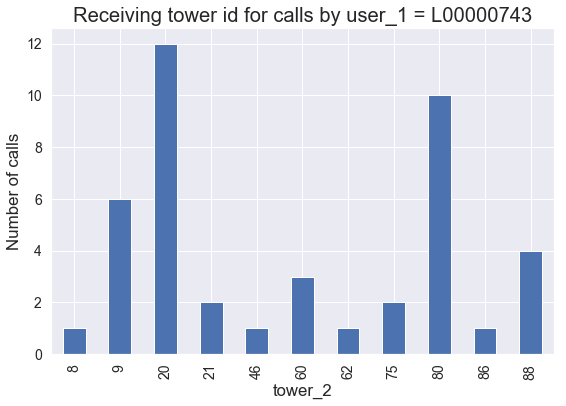

In [154]:
fig, ax = plt.subplots(1)
user1_cdr.groupby(user1_cdr.tower_2).size().sort_index().plot(ax=ax, kind='bar')
ax.set_title("Receiving tower id for calls by user_1 = L00000743")
ax.set_ylabel("Number of calls")

Text(0, 0.5, 'Number of calls')

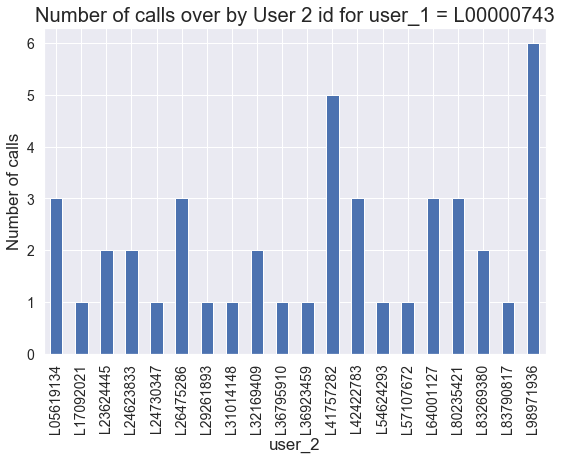

In [155]:
fig, ax = plt.subplots(1)
user1_cdr.groupby(user1_cdr.user_2).size().sort_index().plot(ax=ax, kind='bar')
ax.set_title("Number of calls over by User 2 id for user_1 = L00000743")
ax.set_ylabel("Number of calls")

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

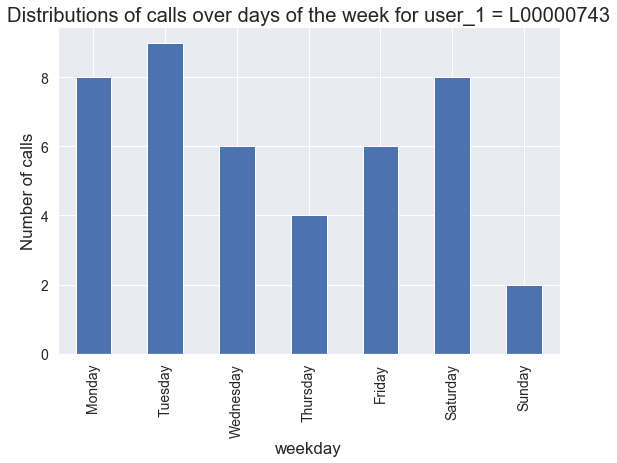

In [156]:
fig, ax = plt.subplots(1)
user1_cdr.groupby(user1_cdr.weekday).size().sort_index().plot(ax=ax, kind='bar')
ax.set_title("Distributions of calls over days of the week for user_1 = L00000743")
ax.set_ylabel("Number of calls")
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
# 0 = Monday, 6 = Sunday

Top 10 districts by outbound calls: [80, 20, 9, 88, 46, 75, 21, 60, 3, 68] <class 'list'>


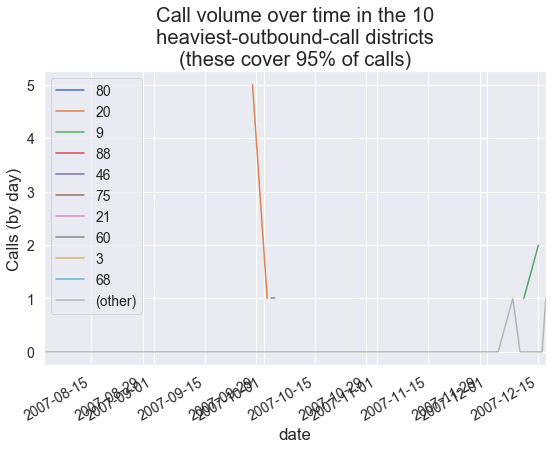

In [157]:
fig, ax = plt.subplots(1)

N = 10
top_districts = list(user1_cdr['tower_1'].value_counts().sort_values(ascending=False)[:N].index)
print("Top %d districts by outbound calls:" % N, top_districts, type(top_districts))
frame = user1_cdr.groupby(['date', 'tower_1']).size().sort_index().unstack()

total_calls = frame.sum().sum()

frame['(other)'] = frame[[c for c in frame.columns if c not in top_districts]].sum(axis=1)
frac_top = 1 - frame['(other)'].sum() / total_calls
frame[top_districts].plot(ax=ax)
frame['(other)'].plot(ax=ax, label='(other)', color='gray', alpha=0.5)
ax.set_title("Call volume over time in the %d\nheaviest-outbound-call districts\n(these cover %.0f%% of calls)" % (
    N, frac_top * 100))
ax.set_ylabel('Calls (by day)')
ax.legend()


Summary of general data exploration over all data is that there is a total of 4388305 calls.

<div style="background-color: #3A3;height: 10px"></div>

## 1.2 Show off your mapping skills

Construct a figure (or two) that provides some geo-spatial intuition behind these data. The `celltower_locations.csv` file will allow you to map towers (referenced in the CDR) to GPS coordinates. Some ideas for what you might do:
 - Construct a heat-map showing the density of frequently visited locations
 - Show a voronoi tesselation of the country, to give an intuition for the density of towers in different locations
 - Assign a 'home location' to each person (up to you how to do so!), and map each person's home location
 - Build a time-series to visualize how the spatial distribution of phone use changes over time
 - Something else creative that you come up with!

Hint: You might considering using [geopandas](http://geopandas.org/) to read shapefile, [shapely](https://github.com/Toblerity/Shapely) to create geometry, and [folium](https://python-visualization.github.io/folium/) to create maps.

Text(0.5, 1.0, 'Districts in Rwanda')

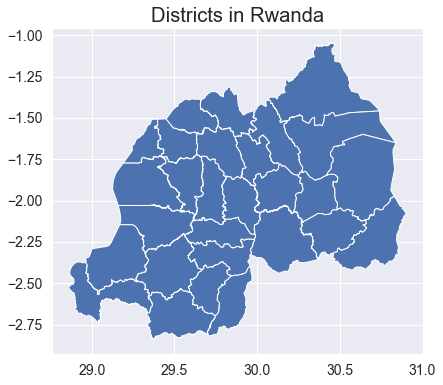

In [35]:
rwanda = geopandas.read_file('datasets/District_Boundary_2012_merge_kigali/District_Boundary_2012.shp')
ax = rwanda.plot()
ax.set_title("Districts in Rwanda")

In [36]:
towers['Coordinates'] = list(zip(towers.longitude, towers.latitude))
towers['Coordinates'] = towers['Coordinates'].apply(Point)
towers = geopandas.GeoDataFrame(towers, geometry='Coordinates')
towers.crs = {'init' :'epsg:4326'}
towers.to_crs(rwanda.crs, inplace=True)
towers.head()

,antenna_id,longitude,latitude,district,Coordinates
antenna_id,,,,,
1,1,30.096104,-1.931660,Kigali,POINT (30.0961040726 -1.93165995865)
3,3,30.122176,-1.997260,Kigali,POINT (30.1221763495 -1.99726023022)
4,4,30.070381,-1.951818,Kigali,POINT (30.070380723 -1.95181811321)
5,5,30.062391,-1.918881,Kigali,POINT (30.0623905641 -1.91888131156)
6,6,30.159390,-2.017144,Kigali,POINT (30.1593900226 -2.01714449483)


Text(0.5,1,'Districts and cell towers in Rwanda')

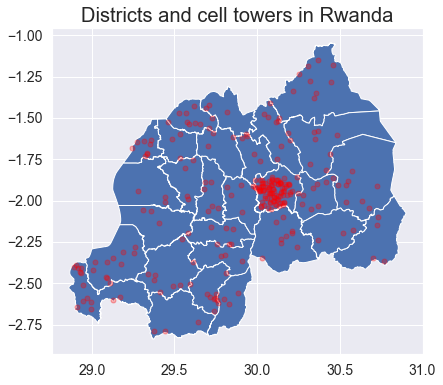

In [10]:
ax = rwanda.plot()
towers.plot(ax=ax, color='red', markersize=25, alpha=0.3)
ax.set_title('Districts and cell towers in Rwanda')

In [37]:
tower_to_district = dict(zip(towers['antenna_id'], towers['district']))
tower_to_coordinates = dict(zip(towers['antenna_id'], towers['Coordinates']))
for i in (1, 2):
    prefix = 'tower_%d' % i
    cdr[prefix + '_district'] = cdr[prefix].map(tower_to_district)
cdr.head()

,user_1,user_2,date,time,tower_1,tower_2,tower_1_district,tower_2_district
0,L55737047,L02196776,2008-06-17,18:30:17,9,9,Rusizi,Rusizi
1,L55737047,L45332350,2008-07-30,21:33:08,47,47,Nyamasheke,Nyamasheke
2,L55737047,L87926818,2008-04-22,14:25:31,74,74,Nyamasheke,Nyamasheke
3,L55737047,L87926818,2008-04-08,15:23:13,20,46,Rusizi,Rusizi
4,L55737047,L87926818,2008-01-23,17:35:49,171,171,Rusizi,Rusizi


In [14]:
rwanda = rwanda.set_index('District', drop=False).sort_index()
for i in (1, 2):
    district_counts = cdr.groupby('tower_%d_district' % i).size()
    rwanda['call_counts_%d' % i] = district_counts
rwanda.head()

,Prov_ID,Prov_Name,Dist_ID,District,NEIGHBORS,SUM,NEIGHBOR_1,SUM_1,NEIGHBOR_2,SUM_2,NEIGHBOR_3,SUM_3,NEIGHBOR_4,SUM_4,NEIGHBOR_5,SUM_5,geometry,call_counts_1,call_counts_2
District,,,,,,,,,,,,,,,,,,,
Bugesera,5.0,Eastern Province,57.0,Bugesera,"51,56,11,26,28,21",1259771250,None,None,None,None,None,None,None,None,None,None,POLYGON ((30.22204918132468 -2.066196614082401...,16499,16534
Burera,4.0,Northern Province,44.0,Burera,"41,45,42,43",1731833690,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.98271183898021 -1.454158943280561...,3904,3931
Gakenke,4.0,Northern Province,42.0,Gakenke,"41,27,44,28,34,35,43",738617326,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.86432983325523 -1.612651983002536...,3325,3477
Gatsibo,5.0,Eastern Province,53.0,Gatsibo,"45,51,52,54",1183971511,None,None,None,None,None,None,None,None,None,None,POLYGON ((30.73912913430223 -1.458219091837464...,23901,24050
Gicumbi,4.0,Northern Province,45.0,Gicumbi,"41,51,52,53,11,44",1819601934,None,None,None,None,None,None,None,None,None,None,POLYGON ((30.18133009500792 -1.518774654026913...,17714,17688


Text(0.5,1,'Outbound call volume by District')

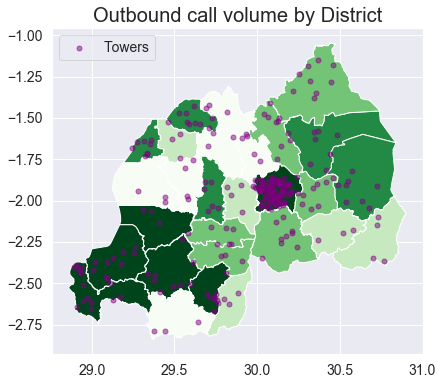

In [13]:
fig, ax = plt.subplots(1)
rwanda.plot(ax=ax, column='call_counts_1', cmap='Greens', scheme='quantiles')
towers.plot(ax=ax, color='purple', markersize=25, alpha=0.5, label='Towers')
ax.legend(loc='upper left')
ax.set_title('Outbound call volume by District')

/Users/everettwetchler/Library/Python/3.7/lib/python/site-packages/geoplot/geoplot.py:2423: UserWarning: Generating a colormap using a categorical column with over 10 individual categories. This is not recommended!
  warnings.warn("Generating a colormap using a categorical column with over 10 individual categories. "


Text(0.5,1,'Voronoi tesselation of Rwanda by cell tower coverage')

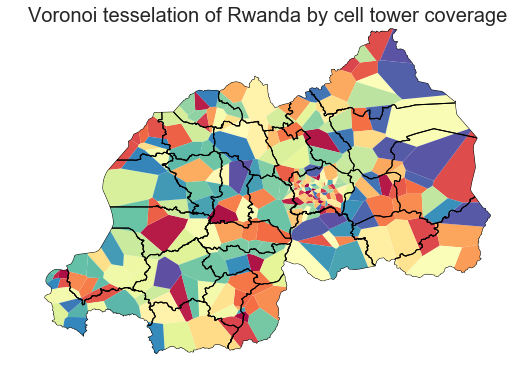

In [14]:
ax = geoplot.voronoi(
    towers, clip=rwanda.geometry,
    categorical=True, hue='antenna_id', cmap='Spectral',
    linewidth=0)
geoplot.polyplot(rwanda, ax=ax, linewidth=1)
ax.set_title('Voronoi tesselation of Rwanda by cell tower coverage')

## Home location

> "Assign a 'home location' to each person (up to you how to do so!), and map each person's home location"

* Let's define "home location" as the most common district where a person is when placing OR receiving a call. We could do something like "center of gravity" but this could easily distort the truth if the person splits their time between two clusters, as it would place them in the middle (where they rarely are).
* This is a little annoying to calculate...

In [40]:
user_district = pd.DataFrame(
    list(zip(cdr['user_1'], cdr['tower_1_district'])) + list(zip(cdr['user_2'], cdr['tower_2_district'])),
    columns=['user_id', 'district'])
print(user_district.shape)
user_district.head()

(8776610, 2)


,user_id,district
0,L55737047,Rusizi
1,L55737047,Nyamasheke
2,L55737047,Nyamasheke
3,L55737047,Rusizi
4,L55737047,Rusizi


In [41]:
counts = user_district.groupby(['user_id', 'district']).size().reset_index(level=(0, 1))
counts = counts.rename(columns={0: 'calls'})
counts.head()

,user_id,district,calls
0,L00000011,Nyamasheke,2
1,L00000719,Kigali,1
2,L00000719,Rusizi,3
3,L00000743,Gisagara,1
4,L00000743,Huye,3


In [42]:
user_max = user_district.groupby(['user_id', 'district']).size().groupby(level=0).max().reset_index(level=0)
user_max.rename(columns={0: 'max_calls'}, inplace=True)
user_max.head()

,user_id,max_calls
0,L00000011,2
1,L00000719,3
2,L00000743,19
3,L00000832,20
4,L00001060,84


In [43]:
user_district = pd.merge(counts, user_max, left_on='user_id', right_on='user_id')
user_district.head(20)

,user_id,district,calls,max_calls
0,L00000011,Nyamasheke,2,2
1,L00000719,Kigali,1,3
2,L00000719,Rusizi,3,3
3,L00000743,Gisagara,1,19
4,L00000743,Huye,3,19
5,L00000743,Kigali,8,19
6,L00000743,Muhanga,2,19
7,L00000743,Nyamasheke,10,19
8,L00000743,Rusizi,19,19
9,L00000832,Nyamasheke,12,20


In [44]:
user_home_district = user_district[user_district['calls'] == user_district['max_calls']]
# Since there may be multiple districts "tied" for this user's most-popular district,
# let's just randomly take the first for the sake of this exercise
user_home_district = user_home_district.drop_duplicates(subset=['user_id']).drop('calls', axis=1)
rwanda['residents'] = user_home_district.groupby('district').size()
rwanda.head()

,Prov_ID,Prov_Name,Dist_ID,District,NEIGHBORS,SUM,NEIGHBOR_1,SUM_1,NEIGHBOR_2,SUM_2,NEIGHBOR_3,SUM_3,NEIGHBOR_4,SUM_4,NEIGHBOR_5,SUM_5,geometry,residents
0,2.0,Southern Province,21.0,Nyanza,"57,26,22,24,25",4498151,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.98354513549964 -2.232735174088987...,NaN
1,2.0,Southern Province,22.0,Gisagara,"23,24,21",4502647,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.70087770154481 -2.810859346681411...,NaN
2,2.0,Southern Province,23.0,Nyaruguru,"22,24,25,36",4518801,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.58804985661567 -2.553842807799299...,NaN
3,2.0,Southern Province,24.0,Huye,"23,22,21,25",13525382,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.84603294096758 -2.453621803203589...,NaN
4,2.0,Southern Province,25.0,Nyamagabe,"26,31,23,24,21,36,37",22612760,None,None,None,None,None,None,None,None,None,None,POLYGON ((29.56211746385003 -2.205764575174953...,NaN


Text(0.5,1,'Outbound call volume by District')

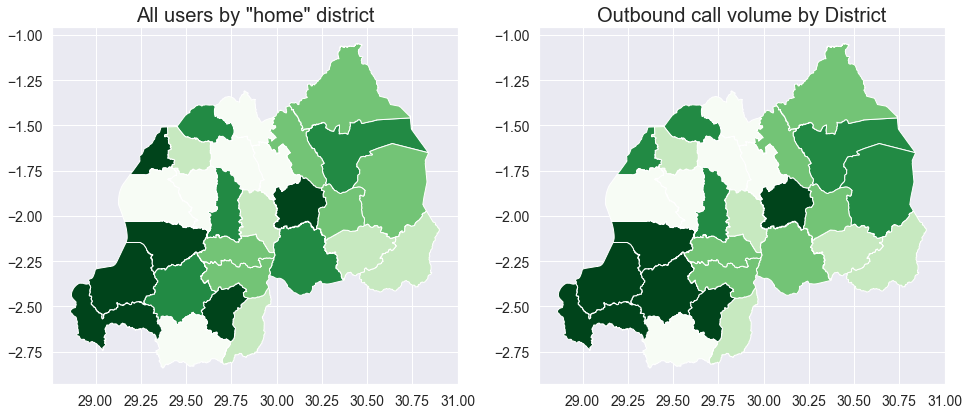

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

ax = axes[0]
rwanda.plot(ax=ax, column='residents', cmap='Greens', scheme='quantiles')
ax.set_title('All users by "home" district')

ax = axes[1]
rwanda.plot(ax=ax, column='call_counts_1', cmap='Greens', scheme='quantiles')
ax.set_title('Outbound call volume by District')

## Plot (and map!) trends in call volume

Text(0.5,1,'Simple plot of daily calls over time')

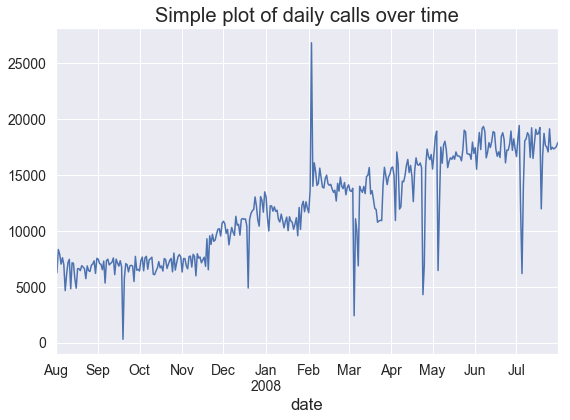

In [21]:
fig, ax = plt.subplots(1)
cdr.groupby(cdr.date).size().sort_index().plot(ax=ax)
ax.set_title("Simple plot of daily calls over time")

Top 3 districts by outbound calls: ['Rusizi', 'Nyamasheke', 'Kigali'] <class 'list'>


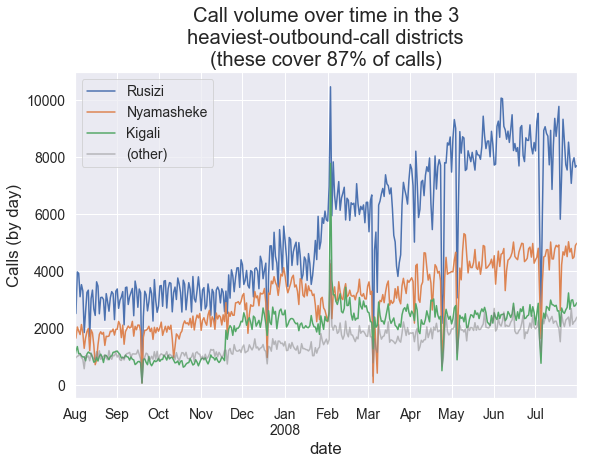

In [22]:
fig, ax = plt.subplots(1)

N = 3
top_districts = list(cdr['tower_1_district'].value_counts().sort_values(ascending=False)[:N].index)
print("Top %d districts by outbound calls:" % N, top_districts, type(top_districts))
frame = cdr.groupby(['date', 'tower_1_district']).size().sort_index().unstack()

total_calls = frame.sum().sum()

frame['(other)'] = frame[[c for c in frame.columns if c not in top_districts]].sum(axis=1)
frac_top = 1 - frame['(other)'].sum() / total_calls
frame[top_districts].plot(ax=ax)
frame['(other)'].plot(ax=ax, label='(other)', color='gray', alpha=0.5)
ax.set_title("Call volume over time in the %d\nheaviest-outbound-call districts\n(these cover %.0f%% of calls)" % (
    N, frac_top * 100))
ax.set_ylabel('Calls (by day)')
ax.legend()

(1556084, 8)
(2832221, 8)


/Users/everettwetchler/Library/Python/3.7/lib/python/site-packages/mapclassify/classifiers.py:673: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Users/everettwetchler/Library/Python/3.7/lib/python/site-packages/mapclassify/classifiers.py:704: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


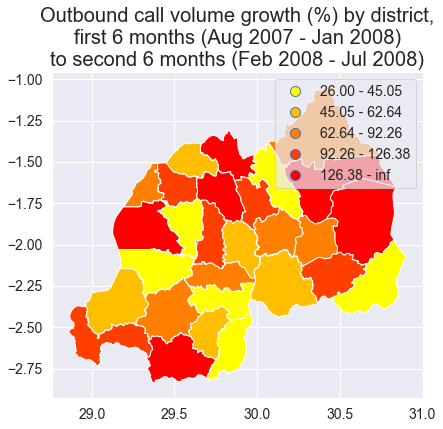

In [23]:
fig, ax = plt.subplots(1)

frame = cdr[cdr.date < dt.datetime(2008, 2, 1)]
print(frame.shape)
key = 'counts_half1'
rwanda[key] = frame.groupby('tower_1_district').size()
rwanda[key] = rwanda[key].fillna(0)

frame = cdr[cdr.date >= dt.datetime(2008, 2, 1)]
print(frame.shape)
key = 'counts_half2'
rwanda[key] = frame.groupby('tower_1_district').size()
rwanda[key] = rwanda[key].fillna(0)

rwanda['counts_change'] = (rwanda['counts_half2'] * 100 / rwanda['counts_half1']) - 100

rwanda.plot(ax=ax, column='counts_change', cmap='autumn_r', scheme='quantiles', legend=True)
ax.set_title('Outbound call volume growth (%) by district,\nfirst 6 months (Aug 2007 - Jan 2008)\nto second 6 months (Feb 2008 - Jul 2008)')
pass

<div style="background-color: #3A3;height: 20px"></div>

# 2. Measuring Migration

## 2.1 Write an (unsupervised) algorithm to infer migration from the CDR

For each individual in the dataset, the CDR provides you with an intermittent stream of their approximate locations over time. What I would like you to do is to convert this streaming log data into a structured dataset that makes it possible to quantify and study internal migration in Rwanda. In particular, use the data you have to quantify the number of migration events that occur in each month that is contained in the CDR. Produce a single time-series figure that has "Year-Month" on the x-axis, and "Number of observed migrations" on the y-axis.

Please note that this is actually a complex task and there are many possible ways to do this. There is no "right" way to do this -- although there are many "wrong" ways. Be creative, but be rigorous. Document and justify the decisions you make along the way, and write a few paragraphs below to summarize your approach and findings.

As a starting point, you should probably review the approach I described in <a href='http://www.tandfonline.com/doi/abs/10.1080/02681102.2011.643209'>"Inferring Patterns of Internal Migration from Mobile Phone Call Records: Evidence from Rwanda"</a>. As discussed in class, that approach has many flaws, so I strongly encourage you to come up with your own approach.

## Approach 1 - follow the paper

In [22]:
all_users = sorted(set(cdr['user_1']) | set(cdr['user_2']))
print("%d total unique users" % len(all_users))

185987 total unique users


In [21]:
# This is the DataFrame we'll be building up
user_metrics = pd.DataFrame(index=all_users)

### Unique towers visited by each user

In [22]:
user_tower = pd.DataFrame(
    list(zip(cdr['user_1'], cdr['tower_1'])) + list(zip(cdr['user_2'], cdr['tower_2'])),
    columns=['user_id', 'tower'])
print(user_tower.shape)

(8776610, 2)


In [23]:
user_unique_towers = user_tower.groupby(['user_id', 'tower']).size().unstack().notnull().sum(axis=1)

In [24]:
user_unique_towers.head()

user_id
L00000011     1
L00000719     3
L00000743    12
L00000832     7
L00001060     6
dtype: int64

In [26]:
user_metrics['n_unique_towers'] = user_unique_towers
user_metrics.head()

,n_unique_towers
L00000011,1
L00000719,3
L00000743,12
L00000832,7
L00001060,6


### Maximum distance travelled ("diameter" of visited towers polygon)

#### NOTE:
* We use lat/long as if they were planar x/y coordinates. This is an approximation, but good enough for our purposes since the total area of Rwanda is small (hence approximately planar) and near the equator (hence 1 deg lat ~= 1 deg long)
* Also, for whatever reason, when I use the `distance` function in shapely I get the same results, so I'm not sure why it seemed to be ignoring the CRS

In [27]:
tower_distances = {}
for t1 in towers.antenna_id:
    for t2 in towers.antenna_id:
        if t2 < t1:
            continue
        dist = towers.loc[t1, 'Coordinates'].distance(towers.loc[t2, 'Coordinates'])
        tower_distances[(t1, t2)] = tower_distances[(t2, t1)] = dist

In [28]:
user_unique_tower = user_tower.drop_duplicates().sort_values(['user_id', 'tower'])

In [29]:
len(user_unique_tower)

875861

In [30]:
# This is much faster than doing groupby and iterating over each user
current_uid = None
current_towers = []
max_dist = 0
user_distances = {}
changes = 1
for uid, t in zip(user_unique_tower['user_id'], user_unique_tower['tower']):
    if current_uid is None:
        current_uid = uid
        current_towers = [t]
    elif current_uid != uid:
        user_distances[current_uid] = max_dist
        max_dist = 0
        current_uid = uid
        current_towers = [t]
    else:
        for t2 in current_towers:
            max_dist = max(max_dist, tower_distances[(t, t2)])
        current_towers.append(t)

# Fence post
user_distances[current_uid] = max_dist

In [31]:
print(len(user_distances))
s = pd.Series(user_distances)
s.head()

185987


L00000011    0.000000
L00000719    1.355742
L00000743    1.282033
L00000832    0.284589
L00001060    1.174364
dtype: float64

In [32]:
user_metrics['max_distance'] = s
user_metrics.head()

,n_unique_towers,max_distance
L00000011,1,0.000000
L00000719,3,1.355742
L00000743,12,1.282033
L00000832,7,0.284589
L00001060,6,1.174364


## Radius of gyration

#### Compute center of gravity

#### NOTE: Let's be clever about this and not brute-force it (that would take forever)

In [31]:
tower_ids = set(towers['antenna_id'])
print(len(tower_ids))

267


In [34]:
user_tower_visits = user_tower.groupby(['user_id', 'tower']).size().unstack().fillna(0)
missing_cols = tower_ids - set(user_tower_visits.columns)
for c in missing_cols:
    user_tower_visits[c] = 0

user_tower_visits = user_tower_visits[sorted(tower_ids)]
user_tower_visits.head()

tower,1,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,40,41,44,45,46,47,48,49,50,54,55,58,59,60,62,...,243,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,274,276,277,278,280,281,282,283,284,285,286,287,288,289,290,291,292,293,295,297,298
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
L00000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
L00000719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
L00000743,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
L00000832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
L00001060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
latsum = user_tower_visits.dot(towers['latitude'])
lonsum = user_tower_visits.dot(towers['longitude'])
user_clat = latsum / user_tower_visits.sum(axis=1)
user_clon = lonsum / user_tower_visits.sum(axis=1)

#### Spot check one user manually

In [36]:
uid = 'L00000719'
clat = user_clat[uid]
clon = user_clon[uid]
print(uid, clat, clon)
s = user_tower_visits.loc[uid]
s[s > 0].to_frame().rename(columns={uid: 'calls'})

L00000719 -2.2962474207175 29.247662614025


,calls
tower,
9,2.0
20,1.0
33,1.0


In [37]:
lat = (towers.loc[9, 'latitude'] * 2 + towers.loc[20, 'latitude'] + towers.loc[33, 'latitude']) / 4
lon = (towers.loc[9, 'longitude'] * 2 + towers.loc[20, 'longitude'] + towers.loc[33, 'longitude']) / 4
print(lat, lon)
assert(abs(clat - lat) < 1e-7)
assert(abs(clon - lon) < 1e-7)

-2.2962474207175 29.247662614025


#### March through the user-tower pairs and add up total travel distance to compute ROG

In [38]:
s = user_tower.groupby(['user_id', 'tower']).size()
s.head()

user_id    tower
L00000011  74       2
L00000719  9        2
           20       1
           33       1
L00000743  3        1
dtype: int64

In [42]:
current_uid = None
clon = clat = 0
current_dist = current_ncalls = 0
user_rog = {}
i = 0
print(len(s))
for (uid, tid), calls in s.items():
    if i % 100000 == 0:
        print(i, (uid, tid, calls))
    if uid != current_uid:
        if current_uid is not None:
            user_rog[current_uid] = np.sqrt(current_dist / current_ncalls)
        current_uid = uid
        clon = user_clon[uid]
        clat = user_clat[uid]
        current_ncalls = 0
        current_dist = 0
    lon, lat = tower_to_coordinates[tid].x, tower_to_coordinates[tid].y
    d = (lon - clon) ** 2 + (lat - clat) ** 2
    current_dist += d * calls
    current_ncalls += calls
    i += 1

# Fence post
user_rog[current_uid] = np.sqrt(current_dist / current_ncalls)

875861
0 ('L00000011', 74, 2)
100000 ('L11491716', 81, 1)
200000 ('L22935591', 168, 6)
300000 ('L34368492', 74, 144)
400000 ('L45776269', 172, 17)
500000 ('L57001997', 166, 6)
600000 ('L68589679', 100, 12)
700000 ('L79971886', 166, 1)
800000 ('L91289285', 171, 6)


In [43]:
user_metrics['rog'] = pd.Series(user_rog)
user_metrics.head()

,n_unique_towers,max_distance,rog
L00000011,1,0.000000,0.000000
L00000719,3,1.355742,0.582477
L00000743,12,1.282033,0.518524
L00000832,7,0.284589,0.103105
L00001060,6,1.174364,0.131006


#### Again, spot check manually

In [44]:
uid = 'L00000719'
clat = user_clat[uid]
clon = user_clon[uid]
print(uid, clat, clon)
s = user_tower_visits.loc[uid]
s[s > 0].to_frame().rename(columns={uid: 'calls'})

L00000719 -2.2962474207175 29.247662614025


,calls
tower,
9,2.0
20,1.0
33,1.0


In [46]:
total = 2 * ((towers.loc[9, 'latitude'] - clat) ** 2 + (towers.loc[9, 'longitude'] - clon) ** 2)
total += (towers.loc[20, 'latitude'] - clat) ** 2 + (towers.loc[20, 'longitude'] - clon) ** 2
total += (towers.loc[33, 'latitude'] - clat) ** 2 + (towers.loc[33, 'longitude'] - clon) ** 2
rog = np.sqrt(total / 4)
print(rog, user_metrics.loc[uid, 'rog'])
assert(abs(rog - user_metrics.loc[uid, 'rog']) < 1e-7)

0.5824773060144623 0.5824773060144623


### For completeness, include home district, COG, and total num calls

In [39]:
user_calls_total = user_tower_visits.sum(axis=1)
user_metrics['calls_total'] = user_calls_total
user_metrics['home_district'] = user_home_district.set_index('user_id')['district']
user_metrics['cog_lon'] = user_clon
user_metrics['cog_lat'] = user_clat

### Summarize what we have so far

In [40]:
user_metrics.head(10)

,n_unique_towers,max_distance,calls_total,home_district,cog_lon,cog_lat
L00000011,1,0.000000,2.0,Nyamasheke,29.086902,-2.465070
L00000719,3,1.355742,4.0,Rusizi,29.247663,-2.296247
L00000743,12,1.282033,43.0,Rusizi,29.279745,-2.334371
L00000832,7,0.284589,32.0,Rusizi,29.081249,-2.529632
L00001060,6,1.174364,163.0,Rusizi,29.080531,-2.500752
L00001147,8,1.308877,14.0,Kigali,29.600902,-2.153282
L00001251,1,0.000000,2.0,Kayonza,30.535453,-2.009250
L00001786,1,0.000000,1.0,Nyamasheke,29.086902,-2.465070
L00002135,6,0.347857,30.0,Nyamasheke,29.128224,-2.378705
L00003611,3,0.113324,13.0,Kigali,30.061268,-1.915685


Text(0.5,0,'Radius of gyration')

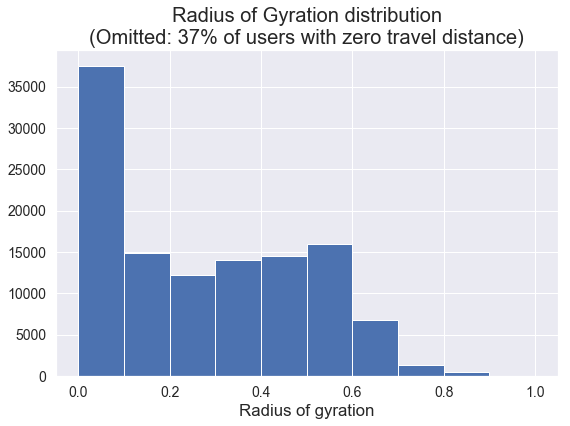

In [49]:
s = user_metrics['rog']
zeros = len(s[s == 0])
# print("%d/%d users (%.0f%%) travelled zero" % (zeros, len(s), zeros * 100 / len(s)))

fig, ax = plt.subplots(1)
s[s > 0].hist(ax=ax, bins=np.arange(0, 1.01, .1))
ax.set_title("Radius of Gyration distribution\n(Omitted: %.0f%% of users with zero travel distance)" %
             (zeros * 100 / len(s)))
ax.set_xlabel('Radius of gyration')

### To reproduce the results, we need the COG and ROG for _each_ month for _each_ user

#### NOTE: This is a near copy-paste of the above code into a function, but we think it pays to have the duplicate above and not simply use the function below, as the above code inspects the process along the way to ensure correctness.

In [26]:
def month_cdr(year, month):
    return cdr[(cdr.date.dt.year == year) & (cdr.date.dt.month == month)]

def calc_month_metrics(year, month):
    frame = month_cdr(year, month)
    if len(frame) == 0:
        return None
    print("Processing %d calls from %d-%02d" % (len(frame), year, month))
    user_tower = pd.DataFrame(
        list(zip(frame['user_1'], frame['tower_1'])) + list(zip(frame['user_2'], frame['tower_2'])),
        columns=['user_id', 'tower'])
    user_metrics = pd.DataFrame(index=all_users)
    user_tower_visits = user_tower.groupby(['user_id', 'tower']).size().unstack().fillna(0)
    missing_cols = tower_ids - set(user_tower_visits.columns)
    for c in missing_cols:
        user_tower_visits[c] = 0

    user_tower_visits = user_tower_visits[sorted(tower_ids)]

    latsum = user_tower_visits.dot(towers['latitude'])
    lonsum = user_tower_visits.dot(towers['longitude'])
    user_clat = latsum / user_tower_visits.sum(axis=1)
    user_clon = lonsum / user_tower_visits.sum(axis=1)

    s = user_tower.groupby(['user_id', 'tower']).size()
    s.head()

    current_uid = None
    clon = clat = 0
    current_dist = current_ncalls = 0
    user_rog = {}
    i = 0
    print('Processing all %d unique user-tower pairs' % (len(s)))
    for (uid, tid), calls in s.items():
        if i % 100000 == 0:
            print(i, (uid, tid, calls))
        if uid != current_uid:
            if current_uid is not None:
                user_rog[current_uid] = np.sqrt(current_dist / current_ncalls)
            current_uid = uid
            clon = user_clon[uid]
            clat = user_clat[uid]
            current_ncalls = 0
            current_dist = 0
        lon, lat = tower_to_coordinates[tid].x, tower_to_coordinates[tid].y
        d = np.sqrt((lon - clon) ** 2 + (lat - clat) ** 2)
        current_dist += d * calls
        current_ncalls += calls
        i += 1

    # Fence post
    user_rog[current_uid] = np.sqrt(current_dist / current_ncalls)

    user_metrics['rog'] = pd.Series(user_rog)
    user_metrics.head()

    user_calls_total = user_tower_visits.sum(axis=1)
    user_metrics['calls_total'] = user_calls_total
    user_metrics['calls_total'] = user_metrics['calls_total'].fillna(0)
    user_metrics['home_district'] = user_home_district.set_index('user_id')['district']
    user_metrics['cog_lon'] = user_clon
    user_metrics['cog_lat'] = user_clat
    return user_metrics

In [45]:
m1 = calc_month_metrics(2007, 8)
m1.head()

Processing 206838 calls from 2007-08
Processing all 77356 unique user-tower pairs
0 ('L00000719', 33, 1)


,rog,calls_total,home_district,cog_lon,cog_lat
L00000011,NaN,0.0,Nyamasheke,NaN,NaN
L00000719,5.960464e-08,1.0,Rusizi,30.198720,-1.959827
L00000743,6.008552e-01,7.0,Rusizi,29.156195,-2.309421
L00000832,NaN,0.0,Rusizi,NaN,NaN
L00001060,2.580907e-01,18.0,Rusizi,29.043118,-2.450889


In [46]:
unique_dates = pd.to_datetime(pd.Series(cdr.date.unique())).sort_values()
unique_months = sorted(set([(d.year, d.month) for d in unique_dates]))
print("%d unique months:" % len(unique_months), unique_months)
month_to_metrics = {}
for y, m in unique_months:
    print(y, m)
    month_to_metrics[(y, m)] = calc_month_metrics(y, m)

12 unique months: [(2007, 8), (2007, 9), (2007, 10), (2007, 11), (2007, 12), (2008, 1), (2008, 2), (2008, 3), (2008, 4), (2008, 5), (2008, 6), (2008, 7)]
2007 8
Processing 206838 calls from 2007-08
Processing all 77356 unique user-tower pairs
0 ('L00000719', 33, 1)
2007 9
Processing 199590 calls from 2007-09
Processing all 73798 unique user-tower pairs
0 ('L00000011', 74, 1)
2007 10
Processing 219792 calls from 2007-10
Processing all 79400 unique user-tower pairs
0 ('L00000719', 9, 2)
2007 11
Processing 243508 calls from 2007-11
Processing all 99146 unique user-tower pairs
0 ('L00000832', 47, 1)
2007 12
Processing 335352 calls from 2007-12
Processing all 140871 unique user-tower pairs
0 ('L00000743', 3, 1)
100000 ('L71173454', 20, 3)
2008 1
Processing 351004 calls from 2008-01
Processing all 149082 unique user-tower pairs
0 ('L00000011', 74, 1)
100000 ('L67243618', 35, 1)
2008 2
Processing 421780 calls from 2008-02
Processing all 182484 unique user-tower pairs
0 ('L00000832', 47, 1)
10

In [48]:
unique_dates.to_csv('datasets/intermediate_files/unique_dates.csv')
with open('datasets/intermediate_files/unique_months.txt', 'w') as filehandle:  
    for listitem in unique_months:
        filehandle.write('%s\n' % str(listitem))
with open('datasets/intermediate_files/month_to_metrics.txt', 'w') as filehandle:  
    for listitem in month_to_metrics:
        filehandle.write('%s\n' % str(listitem))

/anaconda3/envs/geospatial/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [45]:
def cog_movement(y1, m1, y2, m2):
    '''Compute distance in center of gravity between two months for all users.'''
    metrics1 = month_to_metrics[(y1, m1)]
    metrics2 = month_to_metrics[(y2, m2)]
    d = np.sqrt(
            (metrics1['cog_lon'] - metrics2['cog_lon']) ** 2 +
            (metrics1['cog_lat'] - metrics2['cog_lat']) ** 2)
    return d

#### Spot check

In [54]:
s = cog_movement(2007, 9, 2007, 10)
print(len(s))
s.head()

185987


L00000011             NaN
L00000719             NaN
L00000743    3.081965e-01
L00000832             NaN
L00001060    3.552714e-15
dtype: float64

In [55]:
uid = 'L00000743'
print(
    month_to_metrics[(2007, 9)].loc[uid]['cog_lon'],
    month_to_metrics[(2007, 10)].loc[uid]['cog_lon'])
print(
    month_to_metrics[(2007, 9)].loc[uid]['cog_lat'],
    month_to_metrics[(2007, 10)].loc[uid]['cog_lat']
)

28.921983095 29.224466398199997
-2.4078796929116666 -2.466946640805


In [56]:
computed = np.sqrt((29.224466398199997 - 28.921983095) ** 2 + (-2.4078796929116666 - -2.466946640805) ** 2)
print(s.loc[uid], computed)
assert(abs(s.loc[uid] - computed) < 1e-7)

0.3081964520370312 0.3081964520370312


In [46]:
def get_months_from(year, month, month_span, direction='forward'):
    '''Returns a (sorted) list of (year, month) tuples for the
       month_span months preceding ('backward') or following ('forward')
       the given year and month.'''
    if (year, month) not in unique_months:
        return None
    if direction == 'forward':
        start_idx = unique_months.index((year, month))
        end_idx = start_idx + month_span
    elif direction == 'backward':
        end_idx = unique_months.index((year, month))
        start_idx = end_idx - month_span
    else:
        raise ValueError("Specify direction='forward' (or 'backward')")
    if start_idx < 0 or end_idx > len(unique_months):
        return None
    return unique_months[start_idx:end_idx]

In [47]:
def mean_rog(year, month, month_span, direction='forward'):
    '''Compute the mean Radius Of Gyration for B months following/preceding the given month.'''
    months = get_months_from(year, month, month_span, direction=direction)
    if months is None:
        return None
    rogs = pd.DataFrame(index=all_users)
    for m in months:
        rogs[m] = month_to_metrics[m]['rog']
    return rogs.mean(axis=1, skipna=False)

#### Spot check

In [59]:
mean_rog(2008, 1, 2, 'forward').dropna().head()

L00000832    0.246421
L00001060    0.262249
L00003611    0.116686
L00005388    0.686451
L00006410    0.389881
dtype: float64

In [60]:
((month_to_metrics[(2008, 1)]['rog'] + month_to_metrics[(2008, 2)]['rog'])/2).dropna().head()

L00000832    0.246421
L00001060    0.262249
L00003611    0.116686
L00005388    0.686451
L00006410    0.389881
Name: rog, dtype: float64

In [61]:
mean_rog(2008, 1, 2, 'backward').dropna().head()

L00001060    0.257538
L00005388    0.613858
L00013353    0.775088
L00025576    0.086293
L00031456    0.086975
dtype: float64

In [62]:
((month_to_metrics[(2007, 11)]['rog'] + month_to_metrics[(2007, 12)]['rog'])/2).dropna().head()

L00001060    0.257538
L00005388    0.613858
L00013353    0.775088
L00025576    0.086293
L00031456    0.086975
Name: rog, dtype: float64

In [63]:
# Ensure raises an exception for an invalid 'direction'
try:
    mean_rog(2008, 1, 2, 'other').dropna().head()
    assert(False)
except ValueError as e:
    print('ok')

ok


In [64]:
# Ensure returns None when we don't have enough data for the requested window
assert(mean_rog(2007, 9, 2, 'backward') is None)
assert(mean_rog(2008, 7, 1, 'forward') is not None)
assert(mean_rog(2008, 7, 2, 'forward') is None)
assert(mean_rog(2020, 1, 1, 'forward') is None)

### Migration definition (from paper)
> We employ a fairly flexible formulation which defines a migration as occurring at month m if the individual remained in one location for a fixed number of β months prior to m, and was also stationary for β months after and including m, but that the locations pre- and post-m were different. We call two locations r 1 and r 2 the same if the distance between them is less than the individual's ROG times a constant δ.

Formulas:

<img src="formulas_paper.png"/>

In [65]:
def identify_migrants_a(year, month, delta=1):
    '''Return a boolean Series saying if each user satisfied condition 2a.'''
    idx = unique_months.index((year, month))
    if idx == 0:
        return None
    prev_month = unique_months[idx - 1]
    dist = cog_movement(prev_month[0], prev_month[1], year, month)
    return dist > (user_metrics['rog'] * delta)

#### Spot check

In [66]:
migrated_a = identify_migrants_a(2008, 1, delta=1)
print("%d people migrated (%.2f%%)" % (migrated_a.sum(), migrated_a.sum() * 100 / len(migrated_a)))
migrated_a[migrated_a].head()

7729 people migrated (4.16%)


L00026701    True
L00045677    True
L00062412    True
L00065697    True
L00066928    True
dtype: bool

In [67]:
uid = 'L00062412'
print(month_to_metrics[(2007, 12)].loc[uid][['cog_lat', 'cog_lon']].values)
print(month_to_metrics[(2008, 1)].loc[uid][['cog_lat', 'cog_lon']].values)
print(user_metrics.loc[uid, 'rog'])

[-1.91497194542 30.173382910300003]
[-2.382515888116 29.293727537539997]
0.574226248348339


In [68]:
print(np.sqrt((-1.91497194542 - -2.382515888116)**2 + (30.173382910300003 - 29.293727537539997) ** 2))

0.9961881916471732


In [69]:
# For this user, if we double the required movement, they should no longer be a 'migrant'
assert(not identify_migrants_a(2008, 1, delta=2).loc[uid])

In [70]:
def identify_migrants_bc(year, month, beta, delta=1):
    '''Return a boolean Series saying if each user satisfied conditions 2b and 2c.'''
    migrated = pd.Series(index=all_users)
    migrated = True
    for direction in ('forward', 'backward'):
        months = get_months_from(year, month, beta, direction=direction)
        if not months:
            return None
        if direction == 'backward':
            idx = unique_months.index(months[0])
            if idx == 0:
                return None
            months = [unique_months[idx - 1]] + months
        rog = mean_rog(year, month, beta, direction=direction) * delta
        for i, m in enumerate(months[:-1]):
            dist = cog_movement(m[0], m[1],
                                months[i + 1][0], months[i + 1][1])
            migrated = migrated & (dist < rog)
    return migrated

In [71]:
def user_movement(uid):
    '''Compute the COG and ROG for the given user in each month. Useful for plotting.'''
    rows = []
    for i, m in enumerate(unique_months):
        dist = None
        met = month_to_metrics[m]
        lat = met.loc[uid, 'cog_lat']
        lon = met.loc[uid, 'cog_lon']
        dist = None
        if i > 0:
            prev_month = unique_months[i - 1]
            prev_met = month_to_metrics[unique_months[i-1]]
            prev_lat = prev_met.loc[uid, 'cog_lat']
            prev_lon = prev_met.loc[uid, 'cog_lon']
            dist = np.sqrt((prev_lat - lat) ** 2 + (prev_lon - lon) ** 2)
        rows.append(['%d-%02d' % m, lon, lat, met.loc[uid, 'rog'], dist])
    df = pd.DataFrame(rows, columns=['month', 'cog_lon', 'cog_lat', 'rog', 'dist_from_prev']).set_index('month')
    return df

#### Spot check

In [72]:
test_year, test_month, test_beta, test_delta = 2008, 1, 3, 1
migrated_bc = identify_migrants_bc(test_year, test_month, test_beta)
migrated = migrated_a & migrated_bc
print("%d/%d people migrated (%.2f%%)" % (migrated.sum(), len(all_users), migrated.sum() * 100 / len(all_users)))
migrated[migrated].head()

423/185987 people migrated (0.23%)


L00565389    True
L00831938    True
L00910955    True
L00961135    True
L01045598    True
dtype: bool

In [73]:
test_uid = migrated[migrated].index[0]
print(test_uid)
user_metrics.loc[test_uid]

L00565389


n_unique_towers           11
max_distance         0.36593
rog                0.0856807
calls_total              307
home_district         Rusizi
cog_lon              28.9634
cog_lat             -2.44215
Name: L00565389, dtype: object

In [74]:
user_metrics.loc[test_uid]

n_unique_towers           11
max_distance         0.36593
rog                0.0856807
calls_total              307
home_district         Rusizi
cog_lon              28.9634
cog_lat             -2.44215
Name: L00565389, dtype: object

In [75]:
user_movement(test_uid)

,cog_lon,cog_lat,rog,dist_from_prev
month,,,,
2007-08,28.938716,-2.414032,1.594936e-01,NaN
2007-09,28.997774,-2.435085,2.846490e-01,0.062698
2007-10,28.943225,-2.416501,1.946702e-01,0.057628
2007-11,28.926627,-2.408152,9.234538e-02,0.018579
2007-12,28.968280,-2.414733,2.478426e-01,0.042170
2008-01,28.944956,-2.511049,5.960464e-08,0.099100
2008-02,28.951231,-2.497404,1.751356e-01,0.015018
2008-03,28.960421,-2.461697,2.631574e-01,0.036871
2008-04,28.957649,-2.452529,2.496545e-01,0.009578


In [76]:
def movement_geoframe(uid):
    movement = user_movement(uid)
    movement['Coordinates'] = list(zip(movement.cog_lon, movement.cog_lat))
    movement['Coordinates'] = movement['Coordinates'].apply(Point)
    movement = geopandas.GeoDataFrame(movement, geometry='Coordinates')
    return movement

In [77]:
def plot_user_path(id, first_month, last_month, ax=None):
    if not ax:
        ax = rwanda.plot()
    movement = movement_geoframe(uid)
    if first_month and last_month:
        movement = movement.loc[first_month:last_month]
    ax.plot(movement.cog_lon, movement.cog_lat, color='black', linewidth=2, alpha=0.5)
    lon_min = movement.cog_lon.min()
    lon_max = movement.cog_lon.max()
    lon_mid = np.mean([lon_min, lon_max])
    lat_min = movement.cog_lat.min()
    lat_max = movement.cog_lat.max()
    lat_mid = np.mean([lat_min, lat_max])
    dlon = lon_max - lon_min
    dlat = lat_max - lat_min
    d = max(dlon, dlat) * 1.1
    ax.set_xlim((lon_mid - d / 2, lon_mid + d / 2))
    ax.set_ylim((lat_mid - d / 2, lat_mid + d / 2))
    movement.plot(ax=ax, color=[SNS_RED] * 3 + [SNS_GREEN] * 3, markersize=100, alpha=0.7)
    ax.set_title('Migration of user %s\n(RoG = %.3f)' % (
        uid, user_metrics.loc[uid, 'rog']))
    return ax

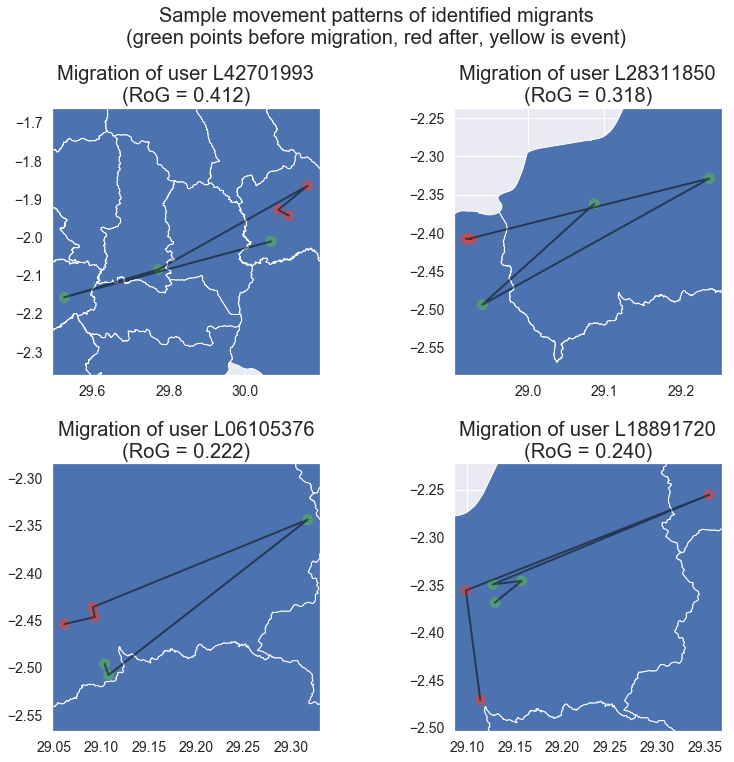

In [78]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
fig.suptitle('Sample movement patterns of identified migrants\n(green points before migration, red after, yellow is event)', fontsize=20)
sample_uids = migrated[migrated].sample(4).index
for ax, uid in zip(axes, sample_uids):
    rwanda.plot(ax=ax)
    plot_user_path(uid, first_month='2007-10', last_month='2008-03', ax=ax)

### Something is strange about these events being called "migrations"
Some people who just seem to move around a lot are called "migrants." Perhaps we should re-define a migration event as simply 2a - any month where your center of gravity changes substantially, relative to your usual radius of gyration. We'll try this later.

In [79]:
### Compute migration rate as a function of other parameters
delta = 1
rows = []
for m in unique_months:
    for beta in range(1, 6):
        s1 = identify_migrants_a(m[0], m[1], delta)
        if s1 is None:
            continue
        s2 = identify_migrants_bc(m[0], m[1], beta)
        if s2 is None:
            continue
        migrations = (s1 & s2).sum()
        row = (dt.datetime(m[0], m[1], 1), beta, migrations)
        print('** Month: %s | Beta: %d | Migration pct: %.2f%%' % (str(m), beta, migrations * 100 / len(all_users)))
        rows.append(row)

df = pd.DataFrame(rows, columns = ['month', 'beta', 'migrations'])
df['month'] = pd.to_datetime(df['month'])

** Month: (2007, 10) | Beta: 1 | Migration pct: 0.54%
** Month: (2007, 11) | Beta: 1 | Migration pct: 0.70%
** Month: (2007, 11) | Beta: 2 | Migration pct: 0.30%
** Month: (2007, 12) | Beta: 1 | Migration pct: 0.87%
** Month: (2007, 12) | Beta: 2 | Migration pct: 0.34%
** Month: (2007, 12) | Beta: 3 | Migration pct: 0.20%
** Month: (2008, 1) | Beta: 1 | Migration pct: 1.18%
** Month: (2008, 1) | Beta: 2 | Migration pct: 0.41%
** Month: (2008, 1) | Beta: 3 | Migration pct: 0.23%
** Month: (2008, 1) | Beta: 4 | Migration pct: 0.14%
** Month: (2008, 2) | Beta: 1 | Migration pct: 1.67%
** Month: (2008, 2) | Beta: 2 | Migration pct: 0.67%
** Month: (2008, 2) | Beta: 3 | Migration pct: 0.40%
** Month: (2008, 2) | Beta: 4 | Migration pct: 0.29%
** Month: (2008, 2) | Beta: 5 | Migration pct: 0.21%
** Month: (2008, 3) | Beta: 1 | Migration pct: 1.60%
** Month: (2008, 3) | Beta: 2 | Migration pct: 0.56%
** Month: (2008, 3) | Beta: 3 | Migration pct: 0.33%
** Month: (2008, 3) | Beta: 4 | Migratio

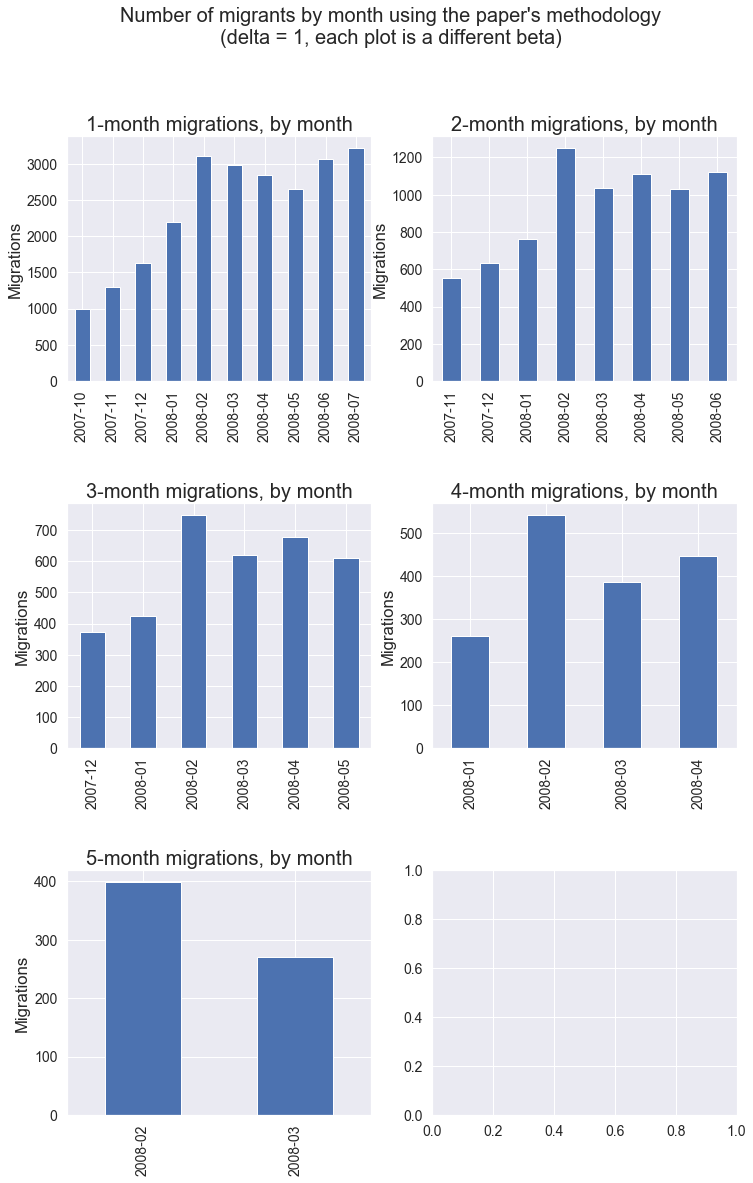

In [80]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 18)
plt.subplots_adjust(hspace=0.5)
axes = axes.flatten()
fig.suptitle('Number of migrants by month using the paper\'s methodology\n'
             '(delta = 1, each plot is a different beta)', fontsize=20)

def plot_migration_counts(ax, beta):
    frame = df[df['beta'] == beta]
    frame.set_index('month', inplace=True)
    frame['migrations'].plot(ax=ax, kind='bar')
    ax.set_title('%d-month migrations, by month' % beta)
    ax.set_xticklabels([t.get_text()[:7] for t in ax.get_xticklabels()])
    ax.set_xlabel('')
    ax.set_ylabel('Migrations')

for ax, beta in zip(axes, range(1, 6)):
    plot_migration_counts(ax, beta)

<div style="background-color: #3A3;height: 10px"></div>

### What if we only use criterion 2a to define a migration event?

In [81]:
rows = []
for delta in (0.5, 1, 2, 4):
    print(delta, end=' ')
    for m in unique_months:
        migrated = identify_migrants_a(m[0], m[1], delta)
        if migrated is None:
            continue
        migrations = migrated.sum()
        row = (dt.datetime(m[0], m[1], 1), delta, migrations)
        rows.append(row)

df = pd.DataFrame(rows, columns = ['month', 'delta', 'migrations'])
df['month'] = pd.to_datetime(df['month'])
df.head()

0.5 1 2 4 

,month,delta,migrations
0,2007-09-01,0.5,6317
1,2007-10-01,0.5,6327
2,2007-11-01,0.5,7769
3,2007-12-01,0.5,11178
4,2008-01-01,0.5,13924


Text(0.5,1,'Migrations per month using ONLY criterion 2a')

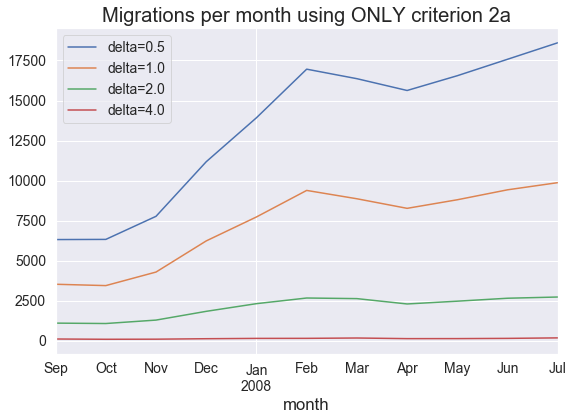

In [82]:
frame = df.groupby(['month', 'delta']).sum().unstack()

fig, ax = plt.subplots(1)
for c in frame.columns:
    frame[c].plot(ax=ax, label='delta=%.1f' % c[1])
ax.legend()
ax.set_title("Migrations per month using ONLY criterion 2a")

## Approach 2

Looking at the data, our logic is that there are three possible explanations for evidence of migration:
1. small-scale movement where movement is explained by bouncing between cell towers
2. repeating travel for work (e.g. on weekly or monthly basis
3. actual migration as in moving location of living

In [13]:
user_call_events = pd.DataFrame(
    list(zip(cdr['user_1'], cdr['tower_1'], cdr['date'])) + list(zip(cdr['user_2'], cdr['tower_2'], cdr['date'])),
    columns=['user_id', 'tower', 'date'])
# print(user_call_events)

In [14]:
user_call_events.to_csv('datasets/user_call_events.csv')
user_call_events.head()

,user_id,tower,date
0,L55737047,9,2008-06-17
1,L55737047,47,2008-07-30
2,L55737047,74,2008-04-22
3,L55737047,20,2008-04-08
4,L55737047,171,2008-01-23


In [57]:
def extract_date_from_string(s):
    event_year, event_month, event_day = s.split('-')
    return dt.date(year=int(event_year), month=int(event_month), day=int(event_day))
# cdr['date'] = pd.to_datetime(cdr.date.apply(extract_date))
# cdr.head()

In [60]:
user_call_events = pd.read_csv("datasets/user_call_events.csv", index_col=[0]) 
user_call_events['date'] = pd.to_datetime(user_call_events.date.apply(extract_date_from_string))
user_call_events.head()

,user_id,tower,date
0,L55737047,9,2008-06-17
1,L55737047,47,2008-07-30
2,L55737047,74,2008-04-22
3,L55737047,20,2008-04-08
4,L55737047,171,2008-01-23


In [16]:
test_row = user_call_events.iloc[0]
test_row

user_id     L55737047
tower               9
date       2008-06-17
Name: 0, dtype: object

In [ ]:
# add lat lon for each tower
def get_tower_lat(row):
    return towers.loc[row.tower,'latitude']
def get_tower_long(row):
    return towers.loc[row.tower,'longitude']

user_call_events['tower_lat'] = user_call_events.apply(get_tower_lat, axis=1)

user_call_events['tower_long'] = user_call_events.apply(get_tower_long, axis=1)
# user_call_events.to_csv('datasets/user_call_event_locations.csv')

In [6]:
# user_call_events.to_csv('datasets/user_call_event_locations.csv')
# user_call_events.head()
# import user_call_events
user_call_locations = pd.read_csv("datasets/user_call_event_locations.csv", index_col=[0]) 

/anaconda3/envs/geospatial/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [61]:

user_call_locations['date'] = pd.to_datetime(user_call_locations.date.apply(extract_date_from_string))
user_call_locations.head()

,user_id,tower,date,tower_lat,tower_long
0,L55737047,9,2008-06-17,-2.408726,28.936417
1,L55737047,47,2008-07-30,-2.499090,29.110623
2,L55737047,74,2008-04-22,-2.465070,29.086902
3,L55737047,20,2008-04-08,-2.407710,28.919096
4,L55737047,171,2008-01-23,-2.602070,29.126979


In [63]:
# user_call_locations[user_call_locations['date'].str.contains('2008-06')]
year = 2008
month = 6
user_call_locations[(user_call_locations.date.dt.year == year) & (user_call_locations.date.dt.month == month)]


,user_id,tower,date,tower_lat,tower_long
0,L55737047,9,2008-06-17,-2.408726,28.936417
10,L55737047,166,2008-06-01,-2.511049,28.944956
12,L55737047,20,2008-06-06,-2.407710,28.919096
15,L55737047,47,2008-06-02,-2.499090,29.110623
20,L55737047,9,2008-06-27,-2.408726,28.936417
29,L55737047,9,2008-06-10,-2.408726,28.936417
41,L55737047,47,2008-06-28,-2.499090,29.110623
56,L55737047,47,2008-06-07,-2.499090,29.110623
82,L55737047,9,2008-06-07,-2.408726,28.936417
87,L55737047,9,2008-06-27,-2.408726,28.936417


In [65]:
len(user_call_events)

8776610

### Spot testing

In [67]:
# for sake of runtime and testing, we will use the previous test user from the data exploration
# id = L00000743
test_user_calls = user_call_locations[user_call_events.user_id == 'L00000743'].sort_values(by=['date'])
print(str(len(test_user_calls)))
test_user_calls.head()

43


,user_id,tower,date,tower_lat,tower_long
3178022,L00000743,75,2007-08-02,-2.033674,29.723993
3178036,L00000743,75,2007-08-02,-2.033674,29.723993
3178035,L00000743,20,2007-08-13,-2.407710,28.919096
3178047,L00000743,20,2007-08-13,-2.407710,28.919096
3178030,L00000743,9,2007-08-28,-2.408726,28.936417


In [68]:
test_movement = test_user_calls
test_movement['Coordinates'] = list(zip(test_user_calls.tower_long, test_user_calls.tower_lat))
test_movement['Coordinates'] = test_movement['Coordinates'].apply(Point)
test_movement = geopandas.GeoDataFrame(test_movement, geometry='Coordinates')
test_movement = test_movement.sort_values(by=['date'])
test_movement.head()

,user_id,tower,date,tower_lat,tower_long,Coordinates
3178022,L00000743,75,2007-08-02,-2.033674,29.723993,POINT (29.7239926589 -2.03367370301)
3178036,L00000743,75,2007-08-02,-2.033674,29.723993,POINT (29.7239926589 -2.03367370301)
3178035,L00000743,20,2007-08-13,-2.407710,28.919096,POINT (28.9190963001 -2.40771039821)
3178047,L00000743,20,2007-08-13,-2.407710,28.919096,POINT (28.9190963001 -2.40771039821)
3178030,L00000743,9,2007-08-28,-2.408726,28.936417,POINT (28.9364170695 -2.40872616642)


Text(0.5, 0, 'Number of calls')

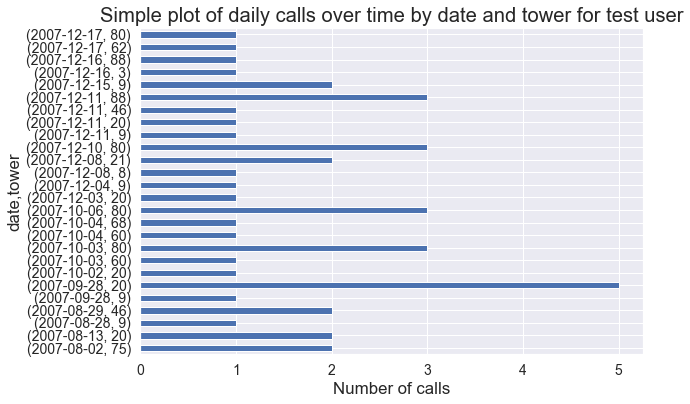

In [126]:
fig, ax = plt.subplots(1)
test_movement.groupby(['date','tower']).size().sort_index().plot(ax=ax, kind="barh")
ax.set_title("Simple plot of daily calls over time by date and tower for test user")
ax.set_xlabel("Number of calls")

Text(0.5, 1.0, 'All Recorded Tower of Call Incoming or Outgoing of User = L00000743')

<Figure size 648x432 with 0 Axes>

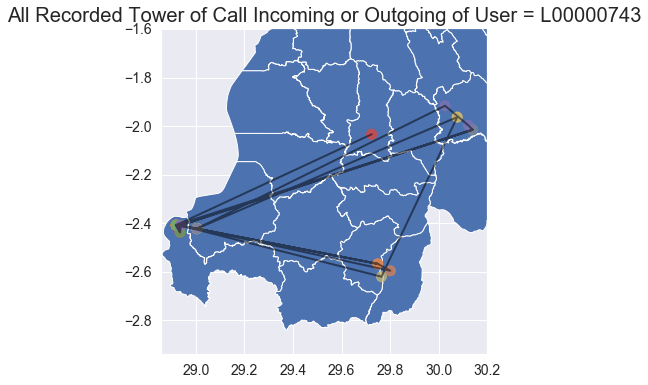

In [127]:
rwanda.plot(ax=ax)
ax = rwanda.plot()

ax.plot(test_movement.tower_long, test_movement.tower_lat, color='black', linewidth=2, alpha=0.5)
lon_min = test_movement.tower_long.min()
lon_max = test_movement.tower_long.max()
lon_mid = np.mean([lon_min, lon_max])
lat_min = test_movement.tower_lat.min()
lat_max = test_movement.tower_lat.max()
lat_mid = np.mean([lat_min, lat_max])
dlon = lon_max - lon_min
dlat = lat_max - lat_min
d = max(dlon, dlat) * 1.1
ax.set_xlim((lon_mid - d / 2, lon_mid + d / 2))
ax.set_ylim((lat_mid - d / 2, lat_mid + d / 2))
test_movement.plot(ax=ax, color=[SNS_RED]*10+[SNS_ORANGE]*10+[SNS_YELLOW]*10+[SNS_GREEN]*7+[SNS_PURPLE]*6, markersize=100, alpha=0.7)
ax.set_title('All Recorded Tower of Call Incoming or Outgoing of User = L00000743')


Text(0.5, 1.0, 'First 15 Recorded Tower of Call Incoming or Outgoing of User = L00000743')

<Figure size 648x432 with 0 Axes>

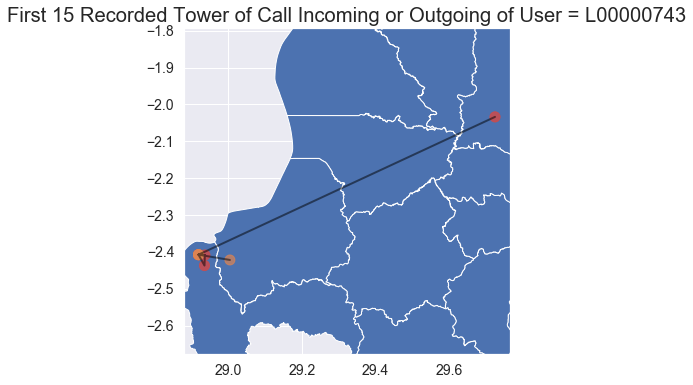

In [54]:
sample_movement = test_movement[:15]
colors = [SNS_RED]*10+[SNS_ORANGE]*10+[SNS_YELLOW]*10+[SNS_GREEN]*7+[SNS_PURPLE]*6
sample_colors = colors[:15]
rwanda.plot(ax=ax)
ax = rwanda.plot()

ax.plot(sample_movement[:20].tower_long, sample_movement.tower_lat, color='black', linewidth=2, alpha=0.5)
lon_min = sample_movement.tower_long.min()
lon_max = sample_movement.tower_long.max()
lon_mid = np.mean([lon_min, lon_max])
lat_min = sample_movement.tower_lat.min()
lat_max = sample_movement.tower_lat.max()
lat_mid = np.mean([lat_min, lat_max])
dlon = lon_max - lon_min
dlat = lat_max - lat_min
d = max(dlon, dlat) * 1.1
ax.set_xlim((lon_mid - d / 2, lon_mid + d / 2))
ax.set_ylim((lat_mid - d / 2, lat_mid + d / 2))
sample_movement.plot(ax=ax, color=sample_colors, markersize=100, alpha=0.7)
ax.set_title('First 15 Recorded Tower of Call Incoming or Outgoing of User = L00000743')


Text(0.5, 1.0, 'Middle 13 Recorded Tower of Call Incoming or Outgoing of User = L00000743')

<Figure size 648x432 with 0 Axes>

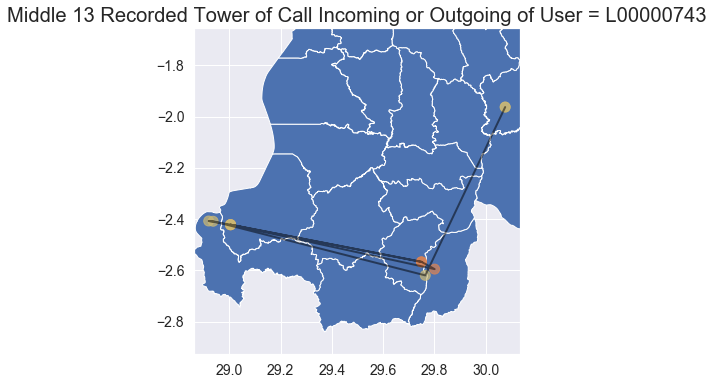

In [55]:
sample_movement = test_movement[15:28]
colors = [SNS_RED]*10+[SNS_ORANGE]*10+[SNS_YELLOW]*10+[SNS_GREEN]*7+[SNS_PURPLE]*6
sample_colors = colors[15:28]
rwanda.plot(ax=ax)
ax = rwanda.plot()

ax.plot(sample_movement[:20].tower_long, sample_movement.tower_lat, color='black', linewidth=2, alpha=0.5)
lon_min = sample_movement.tower_long.min()
lon_max = sample_movement.tower_long.max()
lon_mid = np.mean([lon_min, lon_max])
lat_min = sample_movement.tower_lat.min()
lat_max = sample_movement.tower_lat.max()
lat_mid = np.mean([lat_min, lat_max])
dlon = lon_max - lon_min
dlat = lat_max - lat_min
d = max(dlon, dlat) * 1.1
ax.set_xlim((lon_mid - d / 2, lon_mid + d / 2))
ax.set_ylim((lat_mid - d / 2, lat_mid + d / 2))
sample_movement.plot(ax=ax, color=sample_colors, markersize=100, alpha=0.7)
ax.set_title('Middle 13 Recorded Tower of Call Incoming or Outgoing of User = L00000743')


In [128]:
test_movement[15:28]

,user_id,tower,date,tower_lat,tower_long,Coordinates
3178023,L00000743,60,2007-10-03,-2.566994,29.749220,POINT (29.7492202296 -2.56699402173)
3178018,L00000743,80,2007-10-03,-2.422058,29.004394,POINT (29.0043943056 -2.42205801831)
3178025,L00000743,80,2007-10-03,-2.422058,29.004394,POINT (29.0043943056 -2.42205801831)
3178034,L00000743,60,2007-10-04,-2.566994,29.749220,POINT (29.7492202296 -2.56699402173)
3178043,L00000743,68,2007-10-04,-2.595420,29.800761,POINT (29.8007613891 -2.59541985652)
3178050,L00000743,80,2007-10-06,-2.422058,29.004394,POINT (29.0043943056 -2.42205801831)
3178014,L00000743,80,2007-10-06,-2.422058,29.004394,POINT (29.0043943056 -2.42205801831)
3178054,L00000743,80,2007-10-06,-2.422058,29.004394,POINT (29.0043943056 -2.42205801831)
3178037,L00000743,20,2007-12-03,-2.407710,28.919096,POINT (28.9190963001 -2.40771039821)
3178045,L00000743,9,2007-12-04,-2.408726,28.936417,POINT (28.9364170695 -2.40872616642)


Text(0.5, 1.0, 'Last 15 Recorded Tower of Call Incoming or Outgoing of User = L00000743')

<Figure size 648x432 with 0 Axes>

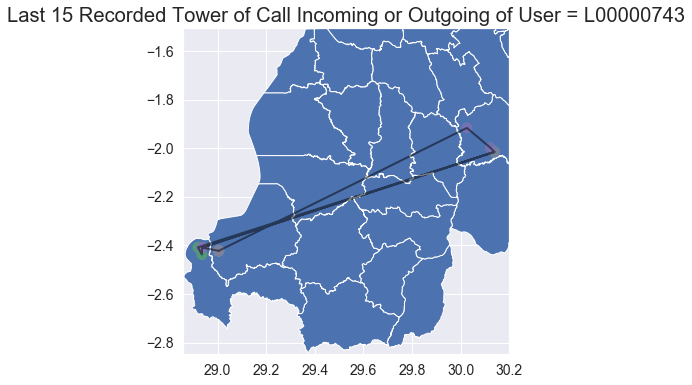

In [57]:
sample_movement = test_movement[28:]
colors = [SNS_RED]*10+[SNS_ORANGE]*10+[SNS_YELLOW]*10+[SNS_GREEN]*7+[SNS_PURPLE]*6
sample_colors = colors[28:]
rwanda.plot(ax=ax)
ax = rwanda.plot()

ax.plot(sample_movement[:20].tower_long, sample_movement.tower_lat, color='black', linewidth=2, alpha=0.5)
lon_min = sample_movement.tower_long.min()
lon_max = sample_movement.tower_long.max()
lon_mid = np.mean([lon_min, lon_max])
lat_min = sample_movement.tower_lat.min()
lat_max = sample_movement.tower_lat.max()
lat_mid = np.mean([lat_min, lat_max])
dlon = lon_max - lon_min
dlat = lat_max - lat_min
d = max(dlon, dlat) * 1.1
ax.set_xlim((lon_mid - d / 2, lon_mid + d / 2))
ax.set_ylim((lat_mid - d / 2, lat_mid + d / 2))
sample_movement.plot(ax=ax, color=sample_colors, markersize=100, alpha=0.7)
ax.set_title('Last 15 Recorded Tower of Call Incoming or Outgoing of User = L00000743')


In [58]:
test_movement[33:].head()

,Unnamed: 0,user_id,tower,date,tower_lat,tower_long,Coordinates
3178040,3178040,L00000743,88,2007-12-11,-2.014970,30.139491,POINT (30.1394906135 -2.01496967526)
3178021,3178021,L00000743,88,2007-12-11,-2.014970,30.139491,POINT (30.1394906135 -2.01496967526)
3178048,3178048,L00000743,20,2007-12-11,-2.407710,28.919096,POINT (28.9190963001 -2.40771039821)
3178013,3178013,L00000743,46,2007-12-11,-2.437227,28.935384,POINT (28.9353838018 -2.43722679681)
3178032,3178032,L00000743,9,2007-12-15,-2.408726,28.936417,POINT (28.9364170695 -2.40872616642)


## Migration Events via Path changes
Migration events occur when routes change. Thus we will compare migration patterns between previous and current month. We use cosine similarity for sequences of tower calls between months (previous to current).


In [70]:
# import dateutil

# test_movement['date'] = test_movement['date'].apply(dateutil.parser.parse)


In [69]:
year = 2007
month = 10
# date_str = str(2007)+'-'+str(10)
# current_month_tower = test_movement[test_movement['date'].str.contains(date_str)]
current_month_tower = test_movement[(test_movement.date.dt.year == year) & (test_movement.date.dt.month == month)].tower.tolist()
current_month_tower

[20, 80, 60, 80, 80, 60, 68, 80, 80, 80]

In [9]:
from collections import Counter
import math

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    if(magA*magB) == 0:
        result = None
    else:
        result = dotprod / (magA * magB)
    return result

def get_list_sim(listA, listB):
    counterA = Counter(listA)
    counterB = Counter(listB)
    return counter_cosine_similarity(counterA, counterB)

# movement will be defined by month where new location or pathways can be extrapolated
def user_movement_by_path(uid):
    '''Compute the COG and ROG for the given user in each month. Useful for plotting.'''
    '''Get monthly paths and compare similarity between current and previous month
        if current month has no calls, then no movement is reported
        if last month has no calls then use last non-null month'''
    rows = []
    sorted_events = user_call_events[user_call_events.user_id == uid].sort_values(by=['date'])
#     print(sorted_events)
    last_month_tower = None
    for i, m in enumerate(unique_months):
        dist = None
        met = month_to_metrics[m]
        lat = met.loc[uid, 'cog_lat']
        lon = met.loc[uid, 'cog_lon']
        dist = None
        year, month = m
        path_sim = None # paths similarity to previous months paths
        current_month_tower = sorted_events[(sorted_events.date.dt.year == year) & (sorted_events.date.dt.month == month)].tower.tolist()
        sim_path = None
        #         print(current_month_tower)
        if i > 0:
            prev_month = unique_months[i - 1]
            prev_met = month_to_metrics[unique_months[i-1]]
            prev_lat = prev_met.loc[uid, 'cog_lat']
            prev_lon = prev_met.loc[uid, 'cog_lon']
            dist = np.sqrt((prev_lat - lat) ** 2 + (prev_lon - lon) ** 2)
            path_sim = get_list_sim(last_month_tower, current_month_tower)
            # set last_month_tower to current_month_tower
        last_month_tower = current_month_tower
        rows.append(['%d-%02d' % m, uid, lon, lat, met.loc[uid, 'rog'], dist, path_sim, current_month_tower])
    df = pd.DataFrame(rows, columns=['month', 'uid', 'cog_lon', 'cog_lat', 'rog', 'dist_from_prev', 'path_sim', 'month_towers']).set_index('month')
    return df

In [70]:
test_uid = 'L00565389'
test_path_by_month = user_movement_by_path(test_uid)
test_path_by_month.iloc[4].month_towers

[20, 20, 9, 80, 80, 9, 9, 20, 46, 47, 20, 20, 125]

We can see from the above that path similarity between months generally ranges between 0.5 to 0.9. For the specific user above, an obvious shift in location occurred in 2008-01, the sequence of towers mostly being 20s and 80s changed 166s. 

If we assume beta to be the cut-off at which path similarity should indicate that a move had occurred, it is not entirely clear where this should be. Using visual inspection, events may be occuring in the above data at 0.34, 0.00, 0.69, and 0.29. Thus we choose betas of 0.1, 0.3, 0.5, and 0.75.

In [133]:
beta = [0.1, 0.3, 0.5, 0.75]
b_labels = ['b0.1', 'b0.3','b0.5','b0.75']
def predict_migrate(df, beta, labels):
    for i, beta_value in enumerate(beta):
        label = b_labels[i]
        df[label] = df['path_sim'] < beta_value
    return df
#         print(b_labels[i])

In [134]:
test_predict_by_path = predict_migrate(test_path_by_month, beta, b_labels)
test_predict_by_path.head()

,uid,cog_lon,cog_lat,rog,dist_from_prev,path_sim,month_towers,b0.1,b0.3,b0.5,b0.75
month,,,,,,,,,,,
2007-08,L00565389,28.938716,-2.414032,0.159494,NaN,NaN,"[20, 20, 9, 9, 20, 9, 20, 20, 20, 9, 20, 20, 9...",False,False,False,False
2007-09,L00565389,28.997774,-2.435085,0.284649,0.062698,0.590248,"[74, 74, 9, 9, 74, 74, 74, 74, 9, 9, 9, 20, 74...",False,False,False,True
2007-10,L00565389,28.943225,-2.416501,0.194670,0.057628,0.340259,"[47, 47, 20, 20, 20, 9, 20, 9, 20, 20, 20, 20,...",False,False,True,True
2007-11,L00565389,28.926627,-2.408152,0.092345,0.018579,0.935448,"[20, 20, 20, 20, 20, 20, 20, 9, 20, 20, 9, 20,...",False,False,False,False
2007-12,L00565389,28.968280,-2.414733,0.247843,0.042170,0.904598,"[20, 20, 9, 80, 80, 9, 9, 20, 46, 47, 20, 20, ...",False,False,False,False


In [135]:
path_values = test_predict_by_path

# path_values 
# month_names
month_names = []
for y, m in unique_months:
    year = str(y)
    if m < 10:
        month = '0'+str(m)
    else:
        month = str(m)
    month_names.append(year+'-'+month)

rows = []
for beta in (0.1, 0.3, 0.5, 0.75):
    print(beta, end=' ')
    for index in month_names:
        values = path_values[path_values.index==index].path_sim < beta
        migrated = values.sum()
        row = (index, beta, migrated)
        rows.append(row)

df = pd.DataFrame(rows, columns = ['month', 'beta', 'migrations'])
df['month'] = pd.to_datetime(df['month'])
df.head()

0.1 0.3 0.5 0.75 

,month,beta,migrations
0,2007-08-01,0.1,0
1,2007-09-01,0.1,0
2,2007-10-01,0.1,0
3,2007-11-01,0.1,0
4,2007-12-01,0.1,0


Text(0.5, 1.0, 'Migrations per month using Monthly Path Similarities')

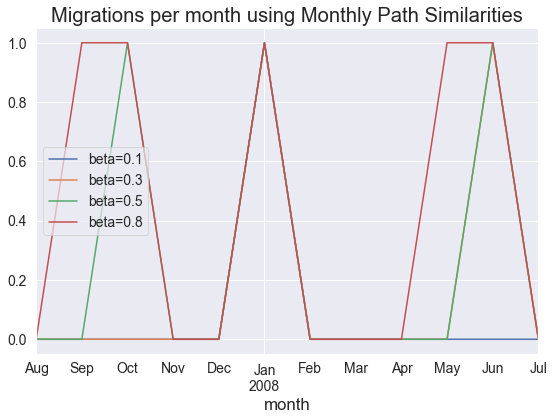

In [136]:
frame = df.groupby(['month', 'beta']).sum().unstack()

fig, ax = plt.subplots(1)
for c in frame.columns:
    frame[c].plot(ax=ax, label='beta=%.1f' % c[1])
ax.legend()
ax.set_title("Migrations per month using Monthly Path Similarities")

### Insert analysis

### Apply to all users

In [72]:
## SHORTER RUN SCRIPT

# movement will be defined by month where new location or pathways can be extrapolated
def user_path_sim(uid):
    '''Get monthly paths and compare similarity between current and previous month
        if current month has no calls, then no movement is reported
        if last month has no calls then use last non-null month'''
    rows = []
    sorted_events = user_call_events[user_call_events.user_id == uid].sort_values(by=['date'])
#     print(sorted_events)
    last_month_tower = None
    for i, m in enumerate(unique_months):
        year, month = m
        path_sim = None # paths similarity to previous months paths
        current_month_tower = sorted_events[(sorted_events.date.dt.year == year) & (sorted_events.date.dt.month == month)].tower.tolist()
        #         print(current_month_tower)
        if i > 0:
            path_sim = get_list_sim(last_month_tower, current_month_tower)
            # set last_month_tower to current_month_tower
        last_month_tower = current_month_tower
        rows.append(['%d-%02d' % m, uid, path_sim, current_month_tower])
    df = pd.DataFrame(rows, columns=['month', 'uid', 'path_sim', 'month_towers']).set_index('month')
    return df

In [161]:
user_call_events.head()

,user_id,tower,date
0,L55737047,9,2008-06-17
1,L55737047,47,2008-07-30
2,L55737047,74,2008-04-22
3,L55737047,20,2008-04-08
4,L55737047,171,2008-01-23


In [73]:

my_df = user_call_events.copy()

# Make a dummy observation to fill in July 2007 so that 'tower last month' (see below) does not overlap with other users.

dummy_df = pd.DataFrame({'user_id':'dummy',
                         'tower': 0,
                         'date': pd.to_datetime('07-2007'),
                         'tower_lat': 0,
                         'tower_long': 0},
                        index = ['dummy'])

my_df = pd.concat([my_df, dummy_df], axis = 0)

# Add a 'month' column - categorical so that months with missing data are filled with NaN on the groupby
my_df['month'] = my_df['date'].dt.to_period('M').astype('category')

# Group the df by user_id and month. This takes about TWO TO FIVE MINUTES
print('initializing groupby...')
my_df = my_df[['user_id','month','tower']].groupby(['user_id','month']).agg(lambda x: list(x))[['tower']]
print('groupby complete!')

# Add a 'tower last month' column, the towers pinged in the previous month
my_df['tower_last_month'] = np.insert(my_df['tower'].values[:-1], 0, np.nan)

# Add columns for tower counters
my_df['tower_counter'] = my_df['tower'].fillna(0).apply(lambda x: Counter(x) if x else Counter())
my_df['tower_last_month_counter'] = my_df['tower_last_month'].fillna(0).apply(lambda x: Counter(x) if x else Counter())

# The counters 'ctrs' column is a tuple of the two tower counters
my_df['ctrs'] = list(zip(my_df['tower_counter'], my_df['tower_last_month_counter']))

# Calculate path similarity
my_df['path_sim'] = my_df['ctrs'].apply(lambda x: counter_cosine_similarity(x[0], x[1]))

# Take only the columns we need and reindex
my_df = my_df[['tower','path_sim']]
my_df = my_df.reset_index(level=0)
my_df.head()

/anaconda3/envs/geospatial/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


initializing groupby...
groupby complete!


,user_id,tower,path_sim
month,,,
2007-07,L00000011,NaN,NaN
2007-08,L00000011,NaN,NaN
2007-09,L00000011,[74],NaN
2007-10,L00000011,NaN,NaN
2007-11,L00000011,NaN,NaN


In [74]:
path_values = my_df
path_values.head()

,user_id,tower,path_sim
month,,,
2007-07,L00000011,NaN,NaN
2007-08,L00000011,NaN,NaN
2007-09,L00000011,[74],NaN
2007-10,L00000011,NaN,NaN
2007-11,L00000011,NaN,NaN


In [75]:
# save path_values to df
path_values.to_csv('datasets/path_values.csv')

In [165]:
# path_values 
# month_names
month_names = []
for y, m in unique_months:
    year = str(y)
    if m < 10:
        month = '0'+str(m)
    else:
        month = str(m)
    month_names.append(year+'-'+month)

rows = []
for beta in (0.1, 0.3, 0.5, 0.75):
    print(beta, end=' ')
    for index in month_names:
        values = path_values[path_values.index==index].path_sim < beta
        migrated = values.sum()
        row = (index, beta, migrated)
        rows.append(row)

beta_migrations = pd.DataFrame(rows, columns = ['month', 'beta', 'migrations'])
beta_migrations['month'] = pd.to_datetime(beta_migrations['month'])
beta_migrations.head()

0.1 0.3 0.5 0.75 

,month,beta,migrations
0,2007-08-01,0.1,0
1,2007-09-01,0.1,3587
2,2007-10-01,0.1,3846
3,2007-11-01,0.1,4370
4,2007-12-01,0.1,5893


In [ ]:
beta_migrations.to_csv('datasets/beta_migrations.csv')


Text(0.5, 1.0, 'Migrations per month using Monthly Path Similarities')

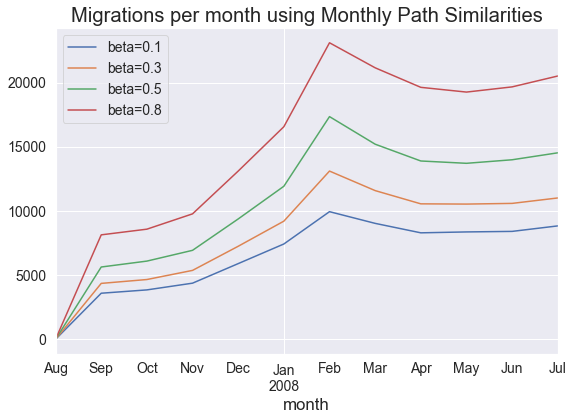

In [166]:
frame = beta_migrations.groupby(['month', 'beta']).sum().unstack()

fig, ax = plt.subplots(1)
for c in frame.columns:
    frame[c].plot(ax=ax, label='beta=%.1f' % c[1])
ax.legend()
ax.set_title("Migrations per month using Monthly Path Similarities")

<div style="background-color: #33A;height: 20px"></div>

# Documentation, justification, interpretation


<div style="background-color: #3A3;height: 20px"></div>

# 3. The Lake Kivu Earthquake

On February 3, 2008, a large earthquake struck the Lake Kivu region of Rwanda and the DRC (see <a href='https://en.wikipedia.org/wiki/2008_Lake_Kivu_earthquake'>wikipedia</a> and <a href='https://earthquake.usgs.gov/earthquakes/eventpage/usp000fy21/executive'>USGS</a> summaries). 

## 3.1 Did the earthquake cause internal displacement?

Use the data at your disposal to study if and how the earthquake affected the mobility and migration decisions of Rwandans. Some questions of interest (answer as many as you can!):
 - Was there an abnormal increase in the number of out-migrations from the affected region?
 - Where did the out-migrants go to?
 - How long did they stay away?

You might want to reference papers such as <a href='http://www.pnas.org/content/109/29/11576.abstract'>"Predictability of Population Displacement after the 2010 Haiti"</a> and  <a href='http://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1001083'>"Improved Response to Disasters and Outbreaks by Tracking Population Movements with Mobile Phone Network Data: A Post-Earthquake Geospatial Study in Haiti"</a>, but again keep in mind that those are early papers that should be read critically, rather than taken as gospel.

## 3.2 How else did the earthquake impact people (as observed in the phone data)?

The earthquake affected much more than the migration decisions of people near the epicenter. Do you observe any other noteworthy changes in human/social behavior following the earthquake? Document any quantitative patterns you observe in the CDR, speculate as to what might really be happening in the lives of the phone users generating the CDR, and discuss what next steps you could take if you wanted to investigate these patterns in greater detail.

A few papers that you might skim as you work on this include <a href='http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0017680'>"Collective Response of Human Populations to Large-Scale Emergencies"</a>, <a href='http://www.aaai.org/ocs/index.php/SSS/SSS10/paper/viewFile/1180/1350'>"People, Quakes, and Communications: Inferences from Call Dynamics about a Seismic Event and its Influences on a Population"</a>, and <a href='http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0120449'>"Spatiotemporal detection of unusual human population behavior using mobile phone data"</a>.

In [82]:
#
# Your code here
#


*Your documentation, justification, interpreation goes here*
